## Morphodynamic and signaling state analysis

##### Load h5 files with image, segmentation, and cell features, apply data-driven modeling and analysis tools

In [1]:
#%%capture
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append('/home/groups/ZuckermanLab/copperma/cell/celltraj/celltraj')
import trajectory
import imageprep as imprep
import utilities
import features
import model
import h5py
import pickle
import os
import subprocess
import time
sys.path.append('/home/groups/ZuckermanLab/copperma/msmWE/BayesianBootstrap')
import bootstrap
import umap
import pyemma.coordinates as coor
import scipy
import csaps
import skimage
from IPython.display import clear_output
import os
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components
np.float=np.dtype(float)
np.int=int
import msmtools
import pandas

Solver suite is petsc
{'python': '3.9.17 | packaged by conda-forge | (main, Aug 10 2023, 07:02:31) | [GCC 12.3.0]', 'fipy': '3.4.4', 'numpy': '1.24.4', 'pysparse': 'not installed', 'scipy': '1.11.1', 'matplotlib': '3.7.2', 'mpi4py': '3.1.5', 'petsc4py': '3.20.2', 'pyamgx': 'not installed', 'PyTrilinos': 'not installed', 'mayavi': '4.8.1', 'gmsh': 'not installed', 'solver': 'petsc'}


##### Specify segmentation model files

In [2]:
date = '2024.04.24'
modelName = f'20240415_T4_LungTrial_AD' #results will be saved/named using this string
datapath='/home/groups/CEDAR/copperma/dyn-cell-sys/vaibhav/20240415_T4_LungTrial_AD'
modelList = imprep.list_images(f'{datapath}/{modelName}_xy*_roi*.h5')
nxy=24
ind_xy = np.arange(nxy).astype(int)

In [ ]:
print(modelList)

In [3]:
#some convenience visualization functions here, eventually these will be incorporated into the packages....
def show_image_3channel(bf_img,nuc_img,rep_img,ax=None):
        if ax is None:
            ax=plt.gca()
        ax.imshow(imprep.znorm(bf_img),cmap=plt.cm.binary,clim=(-5,5))
        cs=ax.contour(imprep.znorm(nuc_img),cmap=plt.cm.BuPu,levels=np.linspace(0,np.percentile(imprep.znorm(nuc_img),99),7),alpha=.5,linewidths=.5)
        cs.cmap.set_over('purple')
        cs=ax.contour(imprep.znorm(rep_img),cmap=plt.cm.YlOrBr_r,levels=np.linspace(0,np.percentile(imprep.znorm(rep_img),99),7),alpha=.25,linewidths=.5)
        cs.cmap.set_over('yellow')
        return ax

def rescale_to_int(img,maxint=255,dtype=np.uint16):
    img=maxint*((img-np.min(img))/np.max(img-np.min(img)))
    return img.astype(dtype)

def show_3dseg_zproj(fig,im3d,labels,fmap=None,fmapscale=None,labels2=None,fmsk=None):
    zproj=np.sum(im3d,axis=0)
    labels_zproj=np.max(labels,axis=0)
    plt.imshow(zproj,cmap=plt.cm.gray_r)
    plt.contour(labels_zproj,levels=np.arange(np.max(labels_zproj)),colors='blue',linewidths=1)
    if fmap is not None:
        #plt.contour(np.max(fmap,axis=0),levels=np.linspace(np.min(fmap),np.max(fmap),21),cmap=plt.cm.PiYG_r)
        plt.imshow(np.max(fmap,axis=0),cmap=plt.cm.YlOrRd,alpha=.33,clim=fmapscale)
    if labels2 is not None:
        labels2_zproj=np.max(labels2,axis=0)
        plt.contour(labels2_zproj,levels=np.arange(np.max(labels2_zproj)),colors='green',linewidths=1)
    if fmsk is not None:
        fmsk_zproj=np.max(fmsk,axis=0)
        plt.contour(fmsk_zproj,levels=np.arange(np.max(fmsk_zproj)),colors='red',linewidths=1)    
    plt.axis('equal');plt.axis('off')

def log_ztransform(img):
    img=np.log(imprep.znorm(img)+1.-np.min(imprep.znorm(img)))
    return img

def nuc_viewtransform(im3d_nuc,zcut_nuc=2.0,rsmooth=1.0,zscale=5.0):
    im3d_nuc=skimage.filters.gaussian(im3d_nuc,sigma=[rsmooth/zscale,rsmooth,rsmooth])
    im3d_nuc=imprep.znorm(im3d_nuc)
    im3d_nuc[im3d_nuc<zcut_nuc]=0
    im3d_nuc=rescale_to_int(log_ztransform(im3d_nuc))
    return im3d_nuc

def bf_viewtransform(im3d_bf,rsmooth=10.0,zscale=5.0,zcut=2.0,remove_background=False):
    im3d_bf=skimage.filters.difference_of_gaussians(im3d_bf,.5,1.5)
    if remove_background:
        im3d_bf_smth=skimage.filters.gaussian(np.abs(im3d_bf),sigma=[rsmooth/zscale,rsmooth,rsmooth])
        msk_bf=imprep.znorm(im3d_bf_smth)>zcut
        msk_bf=binary_fill_holes_2dstack(msk_bf)
    im3d_bf=rescale_to_int(log_ztransform(im3d_bf))
    im3d_bf=np.max(im3d_bf)-im3d_bf
    if remove_background:
        im3d_bf[np.logical_not(msk_bf)]=0
    return im3d_bf

def rep_viewtransform(im3d_rep,rsmooth=1.0,zscale=5.0):
    im3d_rep=skimage.filters.gaussian(im3d_rep,sigma=[rsmooth/zscale,rsmooth,rsmooth])
    im3d_rep=rescale_to_int(log_ztransform(im3d_rep))
    return im3d_rep

def binary_fill_holes_2dstack(im3d):
    for iz in range(im3d.shape[0]):
        im3d[iz,...]=ndimage.binary_fill_holes(im3d[iz,...])
    return im3d

##### Loop through model files and load cell data

In [4]:
tmSet=['ctrl','AREG','IGF1','MEKi'] #,'ctrl2','IGF1','FGF2','AKTi+MEKi','MEKi','AKTi']
nf=len(tmSet)
colorSet =np.array(['black','red','purple','blue']) #,'darkviolet','darkorange','purple','blue','mediumvioletred'])
inds_tmSet=[0]*6+[1]*6+[2]*6+[3]*6
modelList=[]
inds_imagingSet=[0]*nxy
inds_imagingSet_models=[]
inds_tmSet_models=[]
for ii in range(nxy):
    ixy=ind_xy[ii]
    mlist = imprep.list_images(f'{datapath}/{modelName}_xy{ixy}_roi*.h5')
    for mstring in mlist:
        modelList.append(mstring)
        inds_imagingSet_models.append(inds_imagingSet[ii])
        inds_tmSet_models.append(inds_tmSet[ii])
        print(f'found model {mstring} cond: {tmSet[inds_tmSet[ii]]}')

inds_imagingSet_models=np.array(inds_imagingSet_models)
inds_tmSet_models=np.array(inds_tmSet_models)
nmodels=len(modelList)
print(f'{nmodels} models found')
modelSet=[None]*nmodels
indgood_models=np.array([]).astype(int)

found model /home/groups/CEDAR/copperma/dyn-cell-sys/vaibhav/20240415_T4_LungTrial_AD/20240415_T4_LungTrial_AD_xy0_roi0.h5 cond: ctrl
found model /home/groups/CEDAR/copperma/dyn-cell-sys/vaibhav/20240415_T4_LungTrial_AD/20240415_T4_LungTrial_AD_xy1_roi0.h5 cond: ctrl
found model /home/groups/CEDAR/copperma/dyn-cell-sys/vaibhav/20240415_T4_LungTrial_AD/20240415_T4_LungTrial_AD_xy2_roi0.h5 cond: ctrl
found model /home/groups/CEDAR/copperma/dyn-cell-sys/vaibhav/20240415_T4_LungTrial_AD/20240415_T4_LungTrial_AD_xy3_roi0.h5 cond: ctrl
found model /home/groups/CEDAR/copperma/dyn-cell-sys/vaibhav/20240415_T4_LungTrial_AD/20240415_T4_LungTrial_AD_xy3_roi1.h5 cond: ctrl
found model /home/groups/CEDAR/copperma/dyn-cell-sys/vaibhav/20240415_T4_LungTrial_AD/20240415_T4_LungTrial_AD_xy4_roi0.h5 cond: ctrl
found model /home/groups/CEDAR/copperma/dyn-cell-sys/vaibhav/20240415_T4_LungTrial_AD/20240415_T4_LungTrial_AD_xy5_roi0.h5 cond: ctrl
found model /home/groups/CEDAR/copperma/dyn-cell-sys/vaibhav/2

In [5]:
for i in range(nmodels): #now go back through and try to load data
    try:
        modelSet[i]=trajectory.Trajectory(h5filename=modelList[i])
        sctm=modelSet[i]
        status=modelSet[i].load_from_h5('/cell_data_m0/')
        modelSet[i].get_image_shape()#some missing info, add in to metadata in future
        nuc_msk_channel=np.where(sctm.mask_channels==np.array(['nuc']).astype('S32'))[0][0]
        cyto_msk_channel=np.where(sctm.mask_channels==np.array(['cyto']).astype('S32'))[0][0]
        nuc_img_channel=np.where(sctm.channels==np.array(['Cy5']).astype('S32'))[0][0]
        rep_img_channel=np.where(sctm.channels==np.array(['YFP']).astype('S32'))[0][0]
        bf_img_channel=np.where(sctm.channels==np.array(['BF']).astype('S32'))[0][0]
        erk_img_channel=np.where(sctm.channels==np.array(['YFP']).astype('S32'))[0][0]
        akt_img_channel=np.where(sctm.channels==np.array(['TRITC']).astype('S32'))[0][0]
        #fra1_img_channel=np.where(sctm.channels==np.array(['CFP']).astype('S32'))[0][0]
        mskchannel=sctm.mskchannel
        fmskchannel=sctm.fmskchannel
        print(f'loaded {sctm.h5filename} with {sctm.mask_channels} mask channels, {sctm.channels} image channels, cell index on {mskchannel}') 
        if status and modelSet[i].Xf.shape[1]>1:
            if hasattr(modelSet[i],'m0_img1img3_crosscorr'):
                indgood_models=np.append(indgood_models,i)
    except Exception as e:
        print(e)
        pass

loading /home/groups/CEDAR/copperma/dyn-cell-sys/vaibhav/20240415_T4_LungTrial_AD/20240415_T4_LungTrial_AD_xy0_roi0.h5
loading /home/groups/CEDAR/copperma/dyn-cell-sys/vaibhav/20240415_T4_LungTrial_AD/20240415_T4_LungTrial_AD_xy0_roi0.h5
interpreting image as zxyc
interpreting mask as zxyc
loaded /home/groups/CEDAR/copperma/dyn-cell-sys/vaibhav/20240415_T4_LungTrial_AD/20240415_T4_LungTrial_AD_xy0_roi0.h5 with [b'cyto' b'nuc' b'foreground'] mask channels, [b'DAPI' b'Cy5' b'TRITC' b'YFP' b'BF'] image channels, cell index on 0
loading /home/groups/CEDAR/copperma/dyn-cell-sys/vaibhav/20240415_T4_LungTrial_AD/20240415_T4_LungTrial_AD_xy1_roi0.h5
loading /home/groups/CEDAR/copperma/dyn-cell-sys/vaibhav/20240415_T4_LungTrial_AD/20240415_T4_LungTrial_AD_xy1_roi0.h5
interpreting image as zxyc
interpreting mask as zxyc
loaded /home/groups/CEDAR/copperma/dyn-cell-sys/vaibhav/20240415_T4_LungTrial_AD/20240415_T4_LungTrial_AD_xy1_roi0.h5 with [b'cyto' b'nuc' b'foreground'] mask channels, [b'DAPI' 

In [ ]:
indgood_models

In [8]:
#do a quick filtering on models on segmentation stability
nframes=modelSet[0].nt
cellnumber_stdSet=np.ones(nmodels)*np.inf
cellnumber_frames=np.arange(int(nframes/2),nframes).astype(int)
cellnumber_std_cut=100.
meancellSet=np.zeros(nmodels)
for i in indgood_models:
    ncells=np.zeros(nframes)
    ncells_smooth=np.zeros_like(ncells)
    for iS in range(nframes):
        ncells[iS]=np.sum(modelSet[i].cells_frameSet==iS)
    print(f'model {i} mean cellnumber {np.mean(ncells)}')
    meancellSet[i]=np.median(ncells)
    splfov=csaps.CubicSmoothingSpline(np.arange(nframes), ncells/ncells[0], smooth=5.e-2)
    ncells_smooth=splfov(np.arange(nframes))*ncells[0]
    cellnumber_std=np.std(ncells[cellnumber_frames]-ncells_smooth[cellnumber_frames])/np.mean(ncells[cellnumber_frames])
    cellnumber_stdSet[i]=cellnumber_std

indhigh_std=np.where(cellnumber_stdSet>cellnumber_std_cut)[0]
indgood_models=np.setdiff1d(indgood_models,indhigh_std)

model 0 mean cellnumber 2.6164383561643834
model 1 mean cellnumber 8.342465753424657
model 2 mean cellnumber 4.041095890410959
model 3 mean cellnumber 2.6027397260273974
model 4 mean cellnumber 2.958904109589041
model 5 mean cellnumber 3.219178082191781
model 6 mean cellnumber 3.863013698630137
model 7 mean cellnumber 4.712328767123288
model 8 mean cellnumber 1.5342465753424657
model 9 mean cellnumber 3.671232876712329
model 10 mean cellnumber 2.1232876712328768
model 11 mean cellnumber 1.7945205479452055
model 12 mean cellnumber 7.164383561643835
model 13 mean cellnumber 5.342465753424658
model 14 mean cellnumber 4.712328767123288
model 15 mean cellnumber 7.904109589041096
model 16 mean cellnumber 7.616438356164384
model 17 mean cellnumber 0.7534246575342466
model 18 mean cellnumber 3.4246575342465753
model 19 mean cellnumber 2.095890410958904
model 20 mean cellnumber 8.917808219178083
model 21 mean cellnumber 2.1232876712328768
model 22 mean cellnumber 5.287671232876712
model 23 mean

In [ ]:
sctm.channels

In [ ]:
print(indgood_models);print(np.array(modelList)[np.setdiff1d(np.arange(nmodels).astype(int),indgood_models)])

#### Select features and perform PCA

In [9]:
#image features stored in sctm.Xf, often Zernike polynomials, texture, shape, environment, etc
indkeep_features=np.arange(modelSet[indgood_models[0]].Xf.shape[1]).astype(int)
Xf_feature_list=modelSet[indgood_models[0]].Xf_feature_list[indkeep_features]
nfeat=indkeep_features.size
Xf=np.zeros((0,nfeat))
indtreatment=np.array([]).astype(int)
indcellSet=np.array([]).astype(int)
for i in indgood_models:
    Xf=np.append(Xf,modelSet[i].Xf[:,indkeep_features],axis=0)
    indtreatment=np.append(indtreatment,i*np.ones(modelSet[i].Xf.shape[0]).astype(int))
    indcellSet=np.append(indcellSet,modelSet[i].cells_indSet)

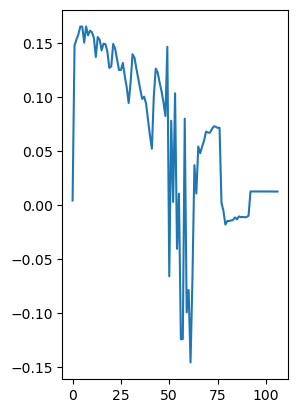

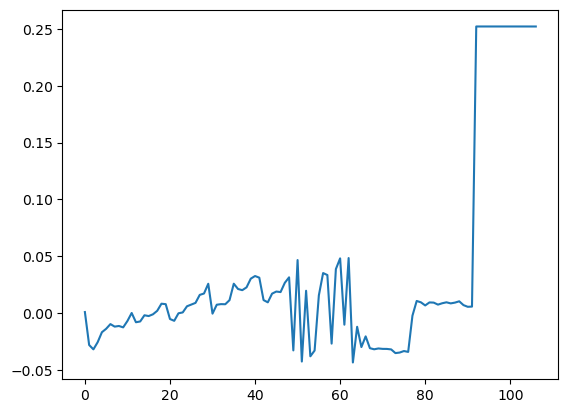

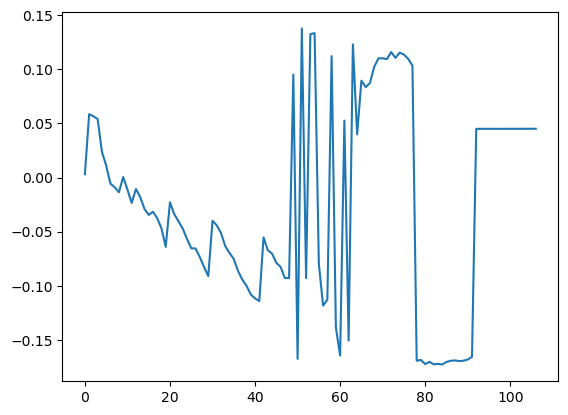

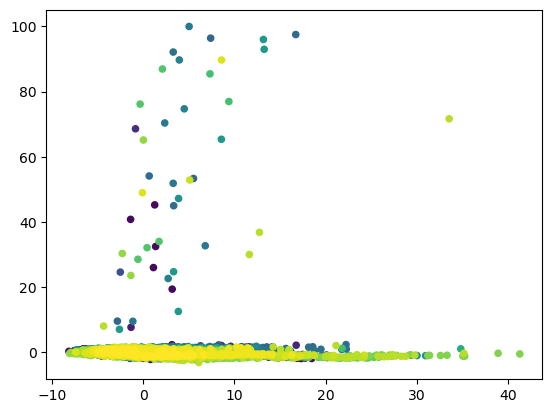

In [10]:
#PCA of image features
#z-norm features
for ifeat in range(Xf.shape[1]): #z-norm all of motility features
    Xf[:,ifeat]=imprep.znorm(Xf[:,ifeat])
    
Xpca,pca=features.get_pca_fromdata(Xf,var_cutoff=.5); pca.ndim=Xpca.shape[1]

plt.clf(); plt.subplot(1,2,1)
for ipca in range(pca.n_components_):
    plt.plot(pca.components_[ipca,:])
    plt.pause(1)

plt.subplot(1,2,2)
plt.clf()
plt.scatter(Xpca[:,0],Xpca[:,1],s=20,c=indtreatment)

In [11]:
#motility features
nfeat_com=3
com_feature_list=np.array(['speed','beta','alpha']).astype('S32')
Xf_com=np.zeros((0,nfeat_com))
for i in indgood_models:
    Xf_com=np.append(modelSet[i].m0_comdx_feat,Xf_com,axis=0)

for icom in range(Xf_com.shape[1]): #z-norm all of motility features
    Xf_com[:,icom]=imprep.znorm(Xf_com[:,icom])

In [12]:
#signaling features
corrc_erk=np.array([]).astype(float)
for i in indgood_models:
    corrc_erk=np.append(corrc_erk,1.-modelSet[i].m0_img0img3_crosscorr)

corrc_erk_std=np.std(corrc_erk);corrc_erk_mean=np.mean(corrc_erk);corrc_erk=imprep.znorm(corrc_erk)

for i in indgood_models:
    corrc_z_model=(np.array([1.-modelSet[i].m0_img0img3_crosscorr]).T-corrc_erk_mean)/corrc_erk_std
    modelSet[i].x_signal=corrc_z_model.copy()

In [ ]:
#signaling features
cratio_erk=np.array([]).astype(float)
for i in indgood_models:
    cratio_erk=np.append(cratio_erk,modelSet[i].img3_m0m1_ratio)

cratio_erk_std=np.std(cratio_erk);cratio_erk_mean=np.mean(cratio_erk);#cratio_erk=imprep.znorm(cratio_erk)

In [13]:
#signaling features
corrc_akt=np.array([]).astype(float)
for i in indgood_models:
    corrc_akt=np.append(corrc_akt,1.-modelSet[i].m0_img0img2_crosscorr)

corrc_akt_std=np.std(corrc_akt);corrc_akt_mean=np.mean(corrc_akt);corrc_akt=imprep.znorm(corrc_akt)
for i in indgood_models:
    corrc_z_model=(np.array([1.-modelSet[i].m0_img0img2_crosscorr]).T-corrc_akt_mean)/corrc_akt_std
    modelSet[i].x_signal_akt=corrc_z_model.copy()

In [ ]:
#signaling features
cratio_akt=np.array([]).astype(float)
for i in indgood_models:
    cratio_akt=np.append(cratio_akt,modelSet[i].img2_m0m1_ratio)

cratio_akt_std=np.std(cratio_akt);cratio_akt_mean=np.mean(cratio_akt);#cratio_akt=imprep.znorm(cratio_akt)

In [ ]:
#signaling features
fra1=np.array([]).astype(float)
indfra1=np.where(Xf_feature_list==b'totalIntensity_msk0img1')[0][0]
for i in indgood_models:
    fra1=np.append(fra1,modelSet[i].Xf[:,indfra1])

fra1_std=np.std(fra1);fra1_mean=np.mean(fra1);fra1=imprep.znorm(fra1)

In [ ]:
plt.scatter(cratio_erk,corrc_erk,s=1,c='black',marker='.')

In [ ]:
plt.scatter(cratio_akt,corrc_akt,s=1,c='black',marker='.')

In [ ]:
sctm.channels

In [ ]:
plt.scatter(corrc_erk,corrc_akt,s=1,c='black',marker='.')

In [14]:
#put the features for embedding into Xpca feature vector
feature_list=[]
for i in range(pca.ndim):
    feature_list.append(f'pca{i}')

#Xpca=np.concatenate((Xpca,Xf_com),axis=1)
#for i in range(len(com_feature_list)):
#    feature_list.append(com_feature_list[i].decode())

Xpca=np.concatenate((Xpca,corrc_erk[:,np.newaxis]),axis=1)
feature_list.append('erk-nuc-corr')

Xpca=np.concatenate((Xpca,corrc_akt[:,np.newaxis]),axis=1)
feature_list.append('akt-nuc-corr')
print(feature_list)

for i in indgood_models:
   indsf=np.where(indtreatment==i)[0]
   modelSet[i].Xpca=Xpca[indsf,:]

['pca0', 'pca1', 'pca2', 'erk-nuc-corr', 'akt-nuc-corr']


#### Trajectory embedding

In [15]:
#Analysis identifiers
date='2024.04.29'
data_id=f'{modelName}_{date}'
os.system(f'mkdir -p {date}')

0

In [16]:
#Map all trajectories
all_trajSet=[None]*nmodels
for i in indgood_models:
    modelSet[i].get_unique_trajectories()
    all_trajSet[i]=modelSet[i].trajectories.copy()

tracked cell 180, 1 tracks, 100 left
tracked cell 0, 1 tracks, 0 left
tracked cell 4, 1 tracks, 0 left
tracked cell 193, 3 tracks, 100 left
tracked cell 0, 1 tracks, 0 left
tracked cell 10, 1 tracks, 0 left
tracked cell 22, 4 tracks, 0 left
tracked cell 4, 1 tracks, 0 left
tracked cell 280, 9 tracks, 200 left
tracked cell 7, 2 tracks, 0 left
tracked cell 2, 1 tracks, 0 left
tracked cell 0, 1 tracks, 0 left
tracked cell 3, 1 tracks, 0 left
tracked cell 29, 2 tracks, 0 left
tracked cell 5, 1 tracks, 0 left
tracked cell 4, 1 tracks, 0 left
tracked cell 340, 2 tracks, 200 left
tracked cell 179, 3 tracks, 100 left
tracked cell 1, 1 tracks, 0 left
tracked cell 197, 1 tracks, 100 left
tracked cell 0, 1 tracks, 0 left
tracked cell 389, 1 tracks, 200 left
tracked cell 4, 1 tracks, 0 left
tracked cell 321, 1 tracks, 200 left
tracked cell 4, 1 tracks, 0 left
tracked cell 2, 1 tracks, 0 left
tracked cell 8, 1 tracks, 0 left
tracked cell 1, 1 tracks, 0 left
tracked cell 219, 1 tracks, 100 left
trac

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


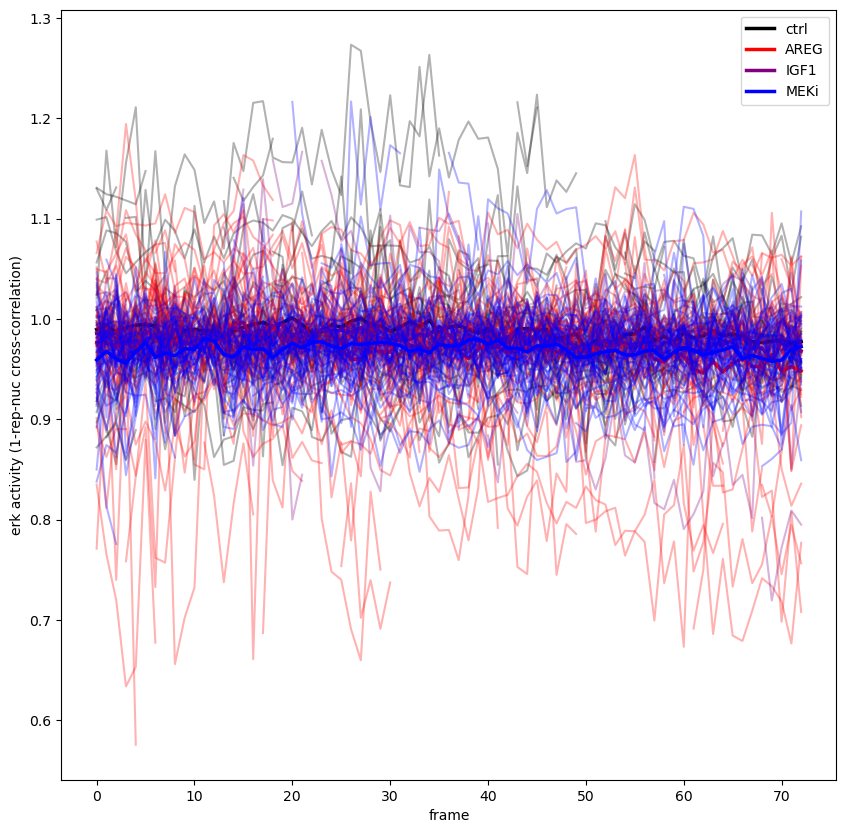

In [18]:
#make a plot of single-cell trajectories, averages, and conditions by frame
min_traj_len=2
fig=plt.figure(figsize=(10,10))
nt=modelSet[0].nt
trajSet_erk=[None]*len(tmSet)
trajSet_akt=[None]*len(tmSet)
#trajSet_fra1=[None]*len(tmSet)
meanSet_erk=[None]*len(tmSet)
meanSet_akt=[None]*len(tmSet)
#meanSet_fra1=[None]*len(tmSet)
for i_tm in range(len(tmSet)):
    indmodels=np.where(inds_tmSet_models==i_tm)[0]
    indmodels=np.intersect1d(indmodels,indgood_models)
    trajs_erk=np.zeros((0,nt))
    trajs_akt=np.zeros((0,nt))
    #trajs_fra1=np.zeros((0,nt))
    frames=np.zeros((0,nt))
    for imodel in indmodels:
        for itraj in range(len(modelSet[imodel].trajectories)):
            trajlen=modelSet[imodel].trajectories[itraj].size
            if trajlen>min_traj_len:
                inds=modelSet[imodel].trajectories[itraj]
                frames=modelSet[imodel].cells_frameSet[inds]
                #cr_erk=modelSet[imodel].img3_m0m1_ratio[inds]
                #cr_akt=modelSet[imodel].img2_m0m1_ratio[inds]
                cr_erk=1.-modelSet[imodel].m0_img0img3_crosscorr[inds]
                cr_akt=1.-modelSet[imodel].m0_img0img2_crosscorr[inds]
                #cr_fra1=modelSet[imodel].Xf[inds,indfra1]
                tr_erk=np.ones(nt)*np.nan
                tr_akt=np.ones(nt)*np.nan
                #tr_fra1=np.ones(nt)*np.nan
                tr_erk[frames]=cr_erk
                tr_akt[frames]=cr_akt
                #tr_fra1[frames]=cr_fra1
                trajs_erk=np.append(trajs_erk,tr_erk[np.newaxis,:],axis=0)
                trajs_akt=np.append(trajs_akt,tr_akt[np.newaxis,:],axis=0)
                #trajs_fra1=np.append(trajs_fra1,tr_fra1[np.newaxis,:],axis=0)
                plt.plot(frames,cr_akt,'-',color=colorSet[i_tm],alpha=.3)
    meanSet_erk[i_tm]=np.nanmean(trajs_erk,axis=0)
    meanSet_akt[i_tm]=np.nanmean(trajs_akt,axis=0)
    #meanSet_fra1[i_tm]=np.nanmean(trajs_fra1,axis=0)
    plt.plot(np.arange(nt),meanSet_akt[i_tm],'-',color=colorSet[i_tm],alpha=1.,linewidth=2.5,label=tmSet[i_tm])
    trajSet_erk[i_tm]=trajs_erk.copy()
    trajSet_akt[i_tm]=trajs_akt.copy()
    #trajSet_fra1[i_tm]=trajs_fra1.copy()

plt.xlabel('frame')
plt.ylabel('erk activity (1-rep-nuc cross-correlation)')
plt.legend(loc='upper right')
plt.savefig(f'{date}/mean_signalingvtime_{data_id}.ps')
        

In [ ]:
for i_tm in range(nf):
    cellindex=np.arange
    df=pandas.DataFrame(data=cellindex)
df['cellid']=cellids
df['frame']=frames
df['field']=fields
df['x']=xset
df['y']=yset
df['fb']=cbset
df.to_csv('CREBi_quantification_JC_31oct22.csv')
    

In [ ]:
min_frame=int(nt/2)
plt.figure(figsize=(7,6))
ax=plt.gca()
n_tm=len(tmSet)
signalSet=[None]*n_tm
for i_tm in range(n_tm):
    setv=trajSet_erk[i_tm][:,min_frame:]
    setv=setv[np.isfinite(setv)]
    if setv.size>0:
        signalSet[i_tm]=setv
        vplot=ax.violinplot(setv,positions=[i_tm+1],showmeans=True,showextrema=False) #,quantiles=[.05,.95])
        vplot['cmeans'].set_color('black')
        for pc in vplot['bodies']:
            pc.set_facecolor(colorSet[i_tm])

ax.set_xticks(range(1,n_tm+1))
ax.set_xticklabels(tmSet)
plt.ylabel('erk (1-nuc-rep cross-correlation)')
plt.xlabel('treatments')
plt.savefig(f'{date}/signaling_erk_tearplot_{data_id}.png')

In [ ]:
min_frame=int(nt/2)
plt.figure(figsize=(7,6))
ax=plt.gca()
n_tm=len(tmSet)
signalSet=[None]*n_tm
for i_tm in range(n_tm):
    setv=trajSet_akt[i_tm][:,min_frame:]
    setv=setv[np.isfinite(setv)]
    if setv.size>0:
        signalSet[i_tm]=setv
        vplot=ax.violinplot(setv,positions=[i_tm+1],showmeans=True,showextrema=False) #,quantiles=[.05,.95])
        vplot['cmeans'].set_color('black')
        for pc in vplot['bodies']:
            pc.set_facecolor(colorSet[i_tm])

ax.set_xticks(range(1,n_tm+1))
ax.set_xticklabels(tmSet)
plt.ylabel('akt (1-nuc-rep cross-correlation)')
plt.xlabel('treatments')
plt.savefig(f'{date}/signaling_akt_tearplot_{data_id}.png')

In [ ]:
min_frame=int(nt/2)
plt.figure(figsize=(7,6))
ax=plt.gca()
n_tm=len(tmSet)
signalSet=[None]*n_tm
ifeat=0 #np.where(modelSet[0].Xf_feature_list==b'meanIntensity_msk0img1')[0][0]
for i_tm in range(n_tm):
    inds=inds_tmSet_models[indtreatment]==i_tm
    setv=Xf_com[inds,ifeat]
    setv=setv[np.isfinite(setv)]
    if setv.size>0:
        signalSet[i_tm]=setv
        vplot=ax.violinplot(setv,positions=[i_tm+1],showmeans=True,showextrema=False) #,quantiles=[.05,.95])
        vplot['cmeans'].set_color('black')
        for pc in vplot['bodies']:
            pc.set_facecolor(colorSet[i_tm])

ax.set_xticks(range(1,n_tm+1))
ax.set_xticklabels(tmSet)
plt.ylabel('motility (<dx> z-norm)')
plt.xlabel('treatments')
plt.ylim(-.62,1.2)
plt.savefig(f'{date}/motility_tearplot_{figid}.png')

Signaling state analysis

In [19]:
#signal environment feature
scut=0.
sigState=np.array([]).astype(int)
for i in indgood_models:
    sigState=np.append(sigState,modelSet[i].x_signal[:,0]>scut)
    modelSet[i].sigState=modelSet[i].x_signal[:,0]>scut

In [ ]:
ray.shutdown()

In [ ]:
ray.init()

In [ ]:
@ray.remote
def get_smean_csize_distributed(imodel,db):
    print(f'?, {imodel}')
    sctm=db[imodel]
    print(sctm.h5filename)
    rsmooth=sctm.cellpose_diam/4.
    zcut=2.0
    csize=np.array([]).astype(int)
    Smean_csize=np.array([]).astype(float)
    for iframe in range(sctm.nt):
        print(f'extracting cluster data for model {imodel}, frame {iframe}')
        msk=sctm.get_mask_data(iframe);
        msk_cyto=msk[...,cyto_msk_channel];
        msk_nuc=msk[...,nuc_msk_channel];
        img_rep=sctm.get_image_data(iframe)[...,rep_img_channel];
        img_rep_smth=skimage.filters.gaussian(img_rep,sigma=[rsmooth/sctm.zscale,rsmooth,rsmooth],mode='mirror')
        fmsk=imprep.znorm(img_rep_smth)>zcut
        indframe=np.where(sctm.cells_frameSet==iframe)[0]
        sigS=sctm.x_signal[indframe]
        fmap=imprep.get_feature_map(sigS,msk_cyto)
        msk_clusters=imprep.get_labeled_mask(fmsk,fill_holes=False)
        for icluster in np.unique(msk_clusters)[1:]:
            print(f'{iframe}, {icluster}')
            indc=np.unique(msk_cyto[msk_clusters==icluster])
            indc=indc[indc>0]-1 #indices one less than labeled mask, ignore 0
            if indc.size>0:
                Smean_csize=np.append(Smean_csize,np.mean(sigS[indc]))
                csize=np.append(csize,indc.size)
    return Smean_csize,csize

In [ ]:
print(tmSet)
inds_tmSet_models

In [ ]:
#get cluster size dependence with signaling
#db_object_ref = ray.put(modelSet)
indmodels_ctrl=np.where(inds_tmSet_models==0)[0]
indmodels=np.intersect1d(indmodels_ctrl,indgood_models)
results2 = ray.get([get_smean_csize_distributed.remote(imodel, modelSet) for imodel in list(indmodels)])

In [ ]:
csize=np.array([]).astype(int)
Smean_csize=np.array([]).astype(float)
inds_csize_models=np.array([]).astype(int)
indmodels=np.where(inds_tmSet_models==0)[0]
indmodels=np.intersect1d(indmodels,indgood_models)
for ii in indmodels:
    iresult=np.where(indgood_models==ii)[0][0]
    csize=np.append(csize,results[iresult][1])
    Smean_csize=np.append(Smean_csize,results[iresult][0])
    inds_csize_models=np.append(inds_csize_models,np.ones_like(csize)*imodel)

In [ ]:
inds_csize_models

In [ ]:
plt.figure(figsize=(7,6))
ax=plt.gca()
for i_size in range(np.max(csize)):
    inds=csize==i_size
    setv=Smean_csize[inds]
    setv=setv[np.isfinite(setv)]
    if setv.size>0:
        vplot=ax.violinplot(setv,positions=[i_size],showmeans=True,showextrema=False) #,quantiles=[.05,.95])
        vplot['cmeans'].set_color('black')
        for pc in vplot['bodies']:
            pc.set_facecolor('purple')

plt.ylabel('fraction ERK on')
plt.xlabel('cluster size')
plt.ylim(0,1.1)
#plt.savefig(f'{date}/smeans_csize_MEKi_{data_id}.png')

In [ ]:
plt.figure(figsize=(7,6))
ax=plt.gca()
for i_tm in range(len(tmSet)):
    indm=np.where(inds_tmSet_models==i_tm)[0]
    inds_csize=np.where(csize==1)[0]
    inds_tm=np.where(np.isin(inds_csize_models,indm))[0]
    inds=np.intersect1d(inds_tm,inds_csize)
    setv=Smean_csize[inds]
    setv=setv[np.isfinite(setv)]
    if setv.size>0:
        vplot=ax.violinplot(setv,positions=[i_tm+1],showmeans=True,showextrema=False) #,quantiles=[.05,.95])
        vplot['cmeans'].set_color('black')
        for pc in vplot['bodies']:
            pc.set_facecolor('purple')

ax.set_xticks(range(1,n_tm+1))
ax.set_xticklabels(tmSet)
plt.xlabel('treatments')
plt.ylabel('mean ERK signal (z-norm)')
#plt.ylim(0,1.1)
#plt.savefig(f'{date}/smeans_csize_{data_id}.png')

In [ ]:
inds_csize

In [ ]:
iframe=0
print(f'extracting cluster data for model {i}, frame {iframe}')
msk=sctm.get_mask_data(iframe);
msk_cyto=msk[...,cyto_msk_channel];
msk_nuc=msk[...,nuc_msk_channel];
img_rep=sctm.get_image_data(iframe)[...,rep_img_channel];
img_rep_smth=skimage.filters.gaussian(img_rep,sigma=[rsmooth/sctm.zscale,rsmooth,rsmooth],mode='mirror')
fmsk=imprep.znorm(img_rep_smth)>zcut
indframe=np.where(sctm.cells_frameSet==iframe)[0]
sigS=sctm.sigState[indframe]
fmap=imprep.get_feature_map(sigS,msk_cyto)
msk_clusters=imprep.get_labeled_mask(fmsk,fill_holes=False)
for icluster in np.unique(msk_clusters)[1:]:
    indc=np.unique(msk_cyto[msk_clusters==icluster])
    indc=indc[indc>0]-1 #indices one less than labeled mask, ignore 0
    if indc.size>0:
        Smean_csize=np.append(Smean_csize,np.mean(sigS[indc]))
        csize=np.append(csize,indc.size)
        if visual_csize and indc.size>0:
            plt.clf()
            print(np.unique(msk_clusters))         
            plt.contour(np.max(fmap,axis=0),levels=[0,1],colors='red')
            img_test=np.zeros_like(img_rep);img_test[msk_clusters==icluster]=np.mean(sigS[indc])
            plt.imshow(np.max(img_test,axis=0),clim=(0,1),cmap=plt.cm.Reds)
            plt.contour(np.max(msk_clusters,axis=0),levels=np.unique(msk_clusters),cmap=plt.cm.Greens)
            plt.pause(.1)

In [ ]:
trajectory

In [20]:
#trajectory embedding
trajl=7
ind_cb=np.where(Xf_feature_list==b'featBoundaryCB-0_msk0img0_fmsk')[0][0]
ind_cbc=np.where(Xf_feature_list==b'featBoundaryCB-0_msk0cmsk0')[0][0]
pca.ndim=modelSet[indgood_models[0]].Xpca.shape[1]
Xpcat=np.zeros((0,pca.ndim*trajl))
indtreatment_traj=np.array([]).astype(int)
indstack_traj=np.array([]).astype(int)
indframes_traj=np.array([]).astype(int)
cellinds0_traj=np.array([]).astype(int)
cellinds1_traj=np.array([]).astype(int)
cbc_ratio_traj=np.array([])
cb_ratio_traj=np.array([])
corrc_erk_traj=np.array([]).astype(float)
z_traj=np.array([]).astype(float)
corrc_erk_full_traj=np.zeros((0,trajl))
corrc_akt_traj=np.array([]).astype(float)
corrc_akt_full_traj=np.zeros((0,trajl))
cbc_ratio_full_traj=np.zeros((0,trajl))
cb_ratio_full_traj=np.zeros((0,trajl))
dx_full_traj=np.zeros((0,trajl))
dx_traj=np.array([])
for i in indgood_models:
    print('building trajectory data for model {}...'.format(i))
    modelSet[i].trajectories=all_trajSet[i].copy()
    modelSet[i].trajl=trajl
    modelSet[i].traj=modelSet[i].get_traj_segments(trajl)
    data=modelSet[i].Xpca[modelSet[i].traj,:]
    #datacom=modelSet[i].Xf_com[modelSet[i].traj,:]
    data=data.reshape(modelSet[i].traj.shape[0],modelSet[i].Xpca.shape[1]*trajl)
    #datacom=datacom.reshape(modelSet[i].traj.shape[0],modelSet[i].Xf_com.shape[1]*trajl)
    #data=np.append(data,datacom,axis=1)
    indgood=np.where(np.sum(np.isnan(data),axis=1)==0)[0]
    data=data[indgood,:]
    modelSet[i].traj=modelSet[i].traj[indgood,:]
    Xpcat=np.append(Xpcat,data,axis=0)
    indtreatment_traj=np.append(indtreatment_traj,i*np.ones(data.shape[0]).astype(int))
    indstacks=modelSet[i].cells_imgfileSet[modelSet[i].traj[:,0]]
    indstack_traj=np.append(indstack_traj,indstacks)
    indframes=modelSet[i].cells_frameSet[modelSet[i].traj[:,0]]
    indframes_traj=np.append(indframes_traj,indframes)
    cellinds0=modelSet[i].traj[:,0]
    cellinds0_traj=np.append(cellinds0_traj,cellinds0)
    cellinds1=modelSet[i].traj[:,-1]
    #cc_ratio=modelSet[i].cc_ratio[cellinds1]
    #cc_ratio_traj=np.append(cc_ratio_traj,cc_ratio)
    cellinds1_traj=np.append(cellinds1_traj,cellinds1)
    corrc_erk_traj=np.append(corrc_erk_traj,1.-modelSet[i].m0_img1img3_crosscorr[cellinds1])
    corrc_erk_full_traj=np.append(corrc_erk_full_traj,1.-modelSet[i].m0_img1img3_crosscorr[modelSet[i].traj],axis=0)
    corrc_akt_traj=np.append(corrc_akt_traj,1.-modelSet[i].m0_img1img2_crosscorr[cellinds1])
    corrc_akt_full_traj=np.append(corrc_akt_full_traj,1.-modelSet[i].m0_img1img2_crosscorr[modelSet[i].traj],axis=0)
    cb_ratio_traj=np.append(cb_ratio_traj,modelSet[i].Xf[cellinds1,ind_cb])
    cb_ratio_full_traj=np.append(cb_ratio_full_traj,modelSet[i].Xf[modelSet[i].traj,ind_cb],axis=0)
    cbc_ratio_traj=np.append(cbc_ratio_traj,modelSet[i].Xf[cellinds1,ind_cbc])
    cbc_ratio_full_traj=np.append(cbc_ratio_full_traj,modelSet[i].Xf[modelSet[i].traj,ind_cbc],axis=0)
    z_traj=np.append(z_traj,np.mean(modelSet[i].cellblocks[:,0],axis=1)[cellinds1])
    dx_traj=np.append(dx_traj,modelSet[i].m0_comdx_feat[cellinds1,0])
    dx_full_traj=np.append(dx_full_traj,modelSet[i].m0_comdx_feat[modelSet[i].traj,0],axis=0)

cellinds0_traj=cellinds0_traj.astype(int)
cellinds1_traj=cellinds1_traj.astype(int)

x=Xpcat #x=np.matmul(Xpcat,np.real(M)) #x=np.concatenate((np.real(np.matmul(Xpcat,M)),np.imag(np.matmul(Xpcat,M))),axis=1) #x=np.concatenate((np.real(phi_X[:,indmodes_M1]),np.imag(phi_X[:,indmodes_M1])),axis=1)
for i in indgood_models:
    modelSet[i].trajectories=all_trajSet[i].copy()

neigen=x.shape[1]
inds_conditions=[None]*nf
for imf in range(nf):
    indmodels=np.intersect1d(indgood_models,np.where(inds_tmSet_models==imf)[0])
    indstm=np.array([])
    for imodel in indmodels:
        indtm=np.where(indtreatment_traj==imodel)
        indstm=np.append(indstm,indtm)
    inds_conditions[imf]=indstm.astype(int).copy()

neigen=x.shape[1]
inds_conditions=[None]*nf
for imf in range(nf):
    indmodels=np.intersect1d(indgood_models,np.where(inds_tmSet_models==imf)[0])
    indstm=np.array([])
    for imodel in indmodels:
        indtm=np.where(indtreatment_traj==imodel)
        indstm=np.append(indstm,indtm)
    inds_conditions[imf]=indstm.astype(int).copy()

#get transitions in the trajectory embedding space
x0set=np.zeros((0,neigen))
x1set=np.zeros((0,neigen))
inds_trajsteps_models=np.array([]).astype(int)
inds_trajsteps=np.zeros((0,2)).astype(int)
for i in indgood_models:
    print('getting flows from model: '+str(i))
    indstm=np.where(indtreatment_traj==i)[0]
    if indstm.size>0:
        modelSet[i].Xtraj=x[indstm,0:neigen]
        indstm_model=indstm-np.min(indstm) #index in model
        modelSet[i].get_trajectory_steps(inds=None,get_trajectories=False,traj=modelSet[i].traj[indstm_model,:],Xtraj=modelSet[i].Xtraj[indstm_model,:])
        x0=modelSet[i].Xtraj0
        x1=modelSet[i].Xtraj1
        x0set=np.append(x0set,x0,axis=0)
        x1set=np.append(x1set,x1,axis=0)
        inds_trajsteps_models=np.append(inds_trajsteps_models,np.ones(x0.shape[0]).astype(int)*i)
        inds_trajsteps=np.append(inds_trajsteps,modelSet[i].inds_trajp1,axis=0)

building trajectory data for model 0...
building trajectory data for model 1...
building trajectory data for model 2...
building trajectory data for model 3...
building trajectory data for model 4...
building trajectory data for model 5...
building trajectory data for model 6...
building trajectory data for model 7...
building trajectory data for model 8...
building trajectory data for model 9...
building trajectory data for model 10...
building trajectory data for model 11...
building trajectory data for model 12...
building trajectory data for model 13...
building trajectory data for model 14...
building trajectory data for model 15...
building trajectory data for model 16...
building trajectory data for model 17...
building trajectory data for model 18...
building trajectory data for model 19...
building trajectory data for model 20...
building trajectory data for model 21...
building trajectory data for model 22...
building trajectory data for model 23...
building trajectory data f

In [ ]:
ray.shutdown()

#### Data-driven modeling

In [21]:
#Analysis identifiers
date='29mar24'
figid=f'{modelName}_tl{trajl}_{date}'
os.system(f'mkdir -p {date}')

0

In [22]:
#get microstate clusters
get_clusters=True
n_clusters=100
knn=10
if get_clusters:
    clusters=coor.cluster_kmeans([x],k=n_clusters,metric='euclidean',fixed_seed=2)
    np.save(f'{date}/clusters_nc{n_clusters}_{figid}.npy',clusters)
else:
    clusters=np.load(f'{date}/clusters_nc{n_clusters}_{figid}.npy',allow_pickle=True)
    clusters=clusters.item()

/home/copperma/mambaforge/envs/celltraj_env/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /home/copperma/mambaforge/envs/celltraj_env/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)


initialize kmeans++ centers:   0%|                                                              | 0/100 [00:00…

kmeans iterations:   0%|                                                                         | 0/10 [00:00…

02-05-24 12:18:25 pyemma.coordinates.clustering.kmeans.KmeansClustering[0] WARNING  Algorithm did not reach convergence criterion of 1e-05 in 10 iterations. Consider increasing max_iter.
Algorithm did not reach convergence criterion of 1e-05 in 10 iterations. Consider increasing max_iter.


/home/copperma/mambaforge/envs/celltraj_env/lib/python3.9/site-packages/deeptime/clustering/_kmeans.py:466: UserWarning: Algorithm did not reach convergence criterion of 1e-05 in 10 iterations. Consider increasing max_iter.
  warnings.warn(f"Algorithm did not reach convergence criterion"


In [40]:
#check out a umap of the embedding space
import sklearn
reducer=sklearn.manifold.TSNE(n_components=2) #, metric='euclidean')
trans = reducer.fit(x.astype(np.float32))
x_umap=trans.embedding_

In [37]:
importlib.reload(umap)

<module 'umap' (namespace)>

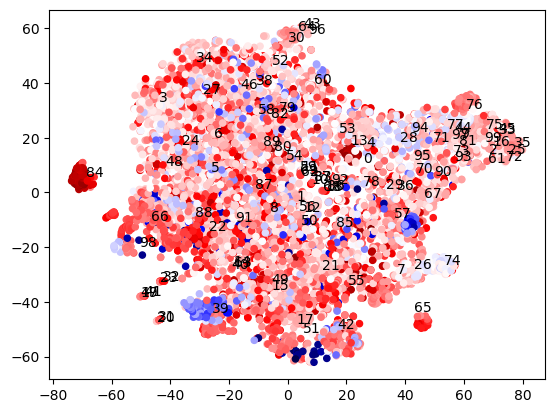

In [41]:
#plot umap of the embedding space
plt.clf()
plt.scatter(x_umap[:,0],x_umap[:,1],s=20,c=corrc_erk_traj,cmap=plt.cm.seismic)
ind_clusters=clusters.assign(x)
x_clusters=np.zeros((n_clusters,2))
for iclust in np.unique(ind_clusters):
    indclust=np.where(ind_clusters==iclust)[0]
    x_clusters[iclust,:]=np.mean(x_umap[indclust,:],axis=0)
    plt.text(x_clusters[iclust,0],x_clusters[iclust,1],str(iclust))

plt.savefig(f'{date}/UMAP_{figid}.png')
plt.pause(.1)

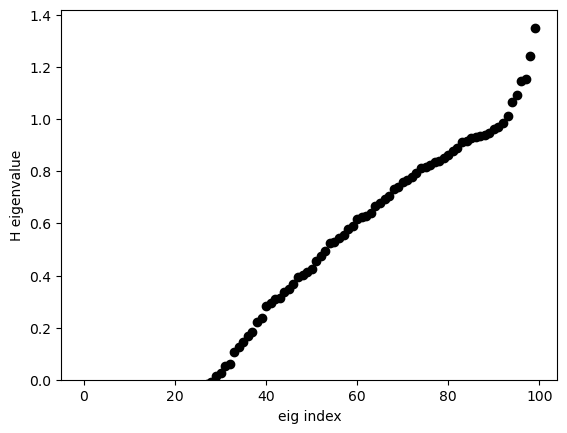

In [42]:
#Markov state model
centers_minima=clusters.clustercenters.copy()
clusters_minima=coor.clustering.AssignCenters(centers_minima, metric='euclidean')
P=model.get_transition_matrix(x0set,x1set,clusters=clusters_minima)
graph = csr_matrix(P>0.)
n_components, labels = connected_components(csgraph=graph, directed=False, return_labels=True)
unique, counts = np.unique(labels, return_counts=True)
icc=unique[np.argmax(counts)]
indcc=np.where(labels==icc)[0]
centers_minima=centers_minima[indcc,:];stateCenters=centers_minima
clusters_minima=coor.clustering.AssignCenters(centers_minima, metric='euclidean')
P=model.get_transition_matrix(x0set,x1set,clusters=clusters_minima)
n_clusters=indcc.size

H=.5*(P+np.transpose(P))+.5j*(P-np.transpose(P))
w,v=np.linalg.eig(H)
w=np.real(w)
indsort=np.argsort(w)
w=w[indsort]
v=v[:,indsort]

plt.clf()
plt.plot(np.arange(n_clusters),w,'ko',label='eigenvalues')
plt.ylim(0,np.max(w)+.05*np.max(w))
plt.xlabel('eig index')
plt.ylabel('H eigenvalue')
plt.pause(.1)

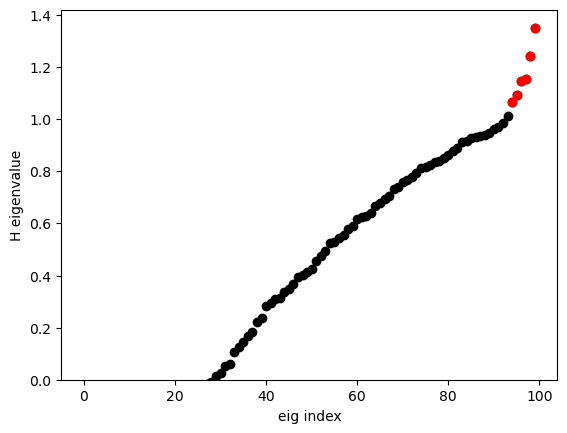

In [43]:
ncomp=6 #number of eigencomponents to keep
vr=np.multiply(w[-ncomp:],np.real(v[:,-ncomp:]))
vi=np.multiply(w[-ncomp:],np.imag(v[:,-ncomp:]))
vkin=np.append(vr,vi,axis=1)
va=np.abs(v[:,-ncomp:])
vkin=np.append(vr,vi,axis=1)
vth=np.arctan2(vr,vi)
plt.clf()
plt.plot(np.arange(n_clusters),w,'ko',label='eigenvalues')
#plt.plot(dense_range,wdense,'k-',label='spline')
plt.plot(np.arange(n_clusters)[-ncomp:],w[-ncomp:],'ro')
plt.ylim(0,np.max(w)+.05*np.max(w))
plt.xlabel('eig index')
plt.ylabel('H eigenvalue')
plt.savefig(f'{date}/eigenvalues_{figid}.png')
plt.pause(.1)

In [46]:
get_cluster_embedding=True
if get_cluster_embedding:
    #reducer=umap.UMAP(n_neighbors=int(n_clusters),min_dist=0.1, n_components=2, metric='euclidean')
    reducer=sklearn.manifold.TSNE(n_components=2)
    trans = reducer.fit(vkin)
    x_clusters=trans.embedding_
    np.save(f'{date}/cluster_embedding_nc{n_clusters}_ncomp{ncomp}_{figid}.npy',x_clusters)
else:
    x_clusters=np.load(f'{date}/cluster_embedding_nc{n_clusters}_ncomp{ncomp}_{figid}.npy')

ind_clusters=clusters_minima.assign(x)
x_clusters_all=x_clusters[ind_clusters,:]

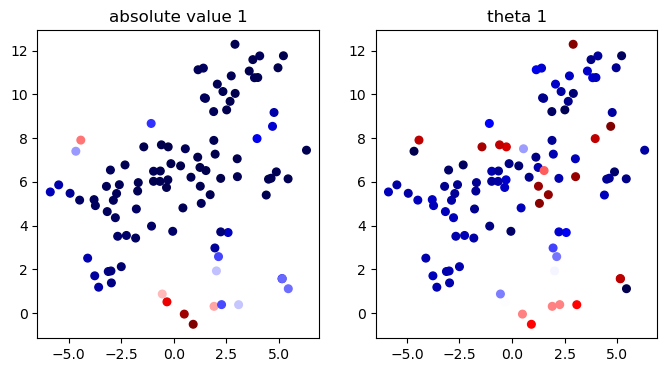

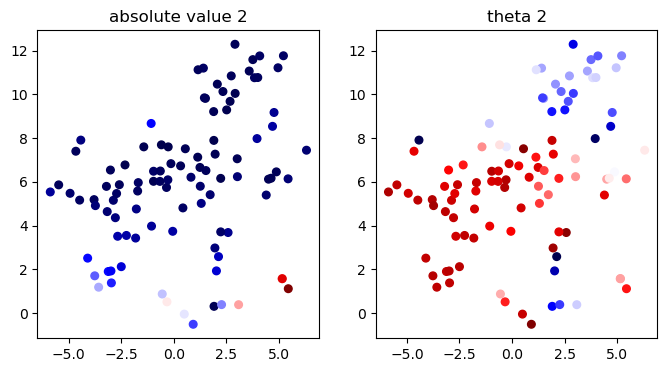

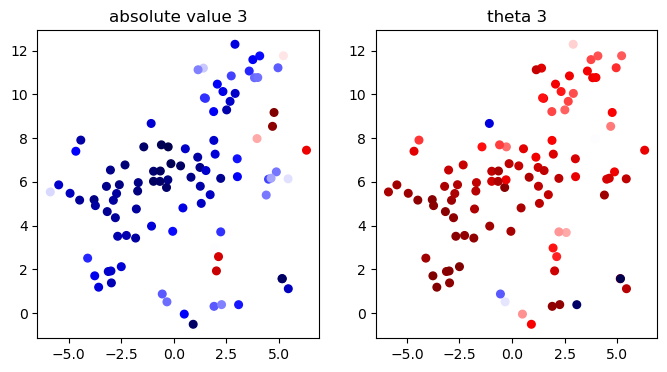

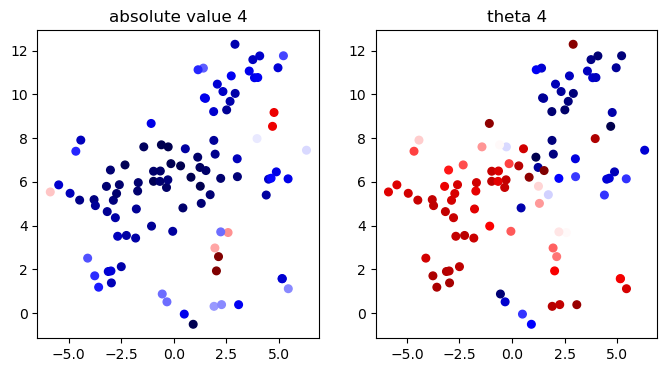

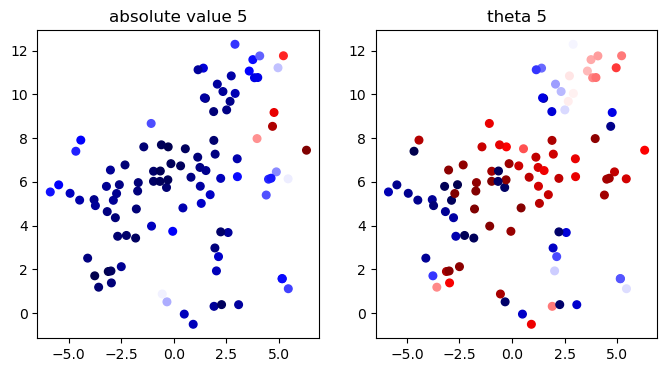

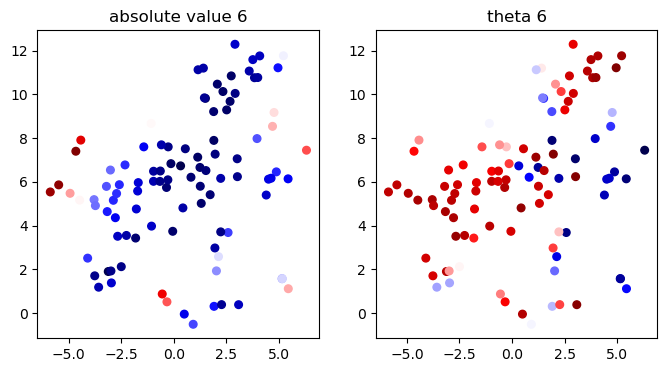

In [47]:
plt.close('all')
for icomp in range(ncomp-1,0-1,-1): #range(ncomp):
    plt.figure(figsize=(8,4))
    plt.clf()
    plt.subplot(1,2,1);plt.scatter(x_clusters[:,0],x_clusters[:,1],s=30,c=va[:,icomp],cmap=plt.cm.seismic)
    plt.title('absolute value '+str(ncomp-icomp))
    plt.subplot(1,2,2);plt.scatter(x_clusters[:,0],x_clusters[:,1],s=30,c=vth[:,icomp],cmap=plt.cm.seismic)
    plt.title('theta '+str(ncomp-icomp))
    plt.pause(1);plt.savefig(date+'/componentrth_'+str(ncomp-icomp)+'_H_nc'+str(n_clusters)+'_ncomp'+str(ncomp)+'_'+figid+'.png');plt.close()

In [48]:
dx_clusters=np.zeros((nf,n_clusters,2))
MtSet=[None]*nf
for i in range(nf):
    indmodels=np.where(inds_tmSet_models==i)[0]
    indstm=np.array([]).astype(int)
    for imodel in indmodels:
        indstm=np.append(indstm,np.where(inds_trajsteps_models==imodel)[0].astype(int))
    x0=x0set[indstm,:]
    x1=x1set[indstm,:]
    Mt=model.get_transition_matrix(x0,x1,clusters_minima)
    MtSet[i]=Mt.copy()
    dxmatrix=np.zeros((n_clusters,n_clusters,2))
    for ii in range(n_clusters):
        for jj in range(n_clusters):
            dxmatrix[ii,jj]=(x_clusters[jj,:]-x_clusters[ii,:])*Mt[ii,jj]
    dx_clusters[i,:,:]=np.sum(dxmatrix,axis=1)

dx_clusters_smooth=np.zeros_like(dx_clusters)
knn=10
for i in range(nf):
    for iclust in range(n_clusters):
        xc=np.array([clusters_minima.clustercenters[iclust,:]])
        dmatr=utilities.get_dmat(clusters_minima.clustercenters,xc) #get closest cells to cluster center
        indr=np.argsort(dmatr[:,0])
        indr=indr[0:knn]
        dx_clusters_smooth[i,iclust,:]=np.mean(dx_clusters[i,indr,:],axis=0)

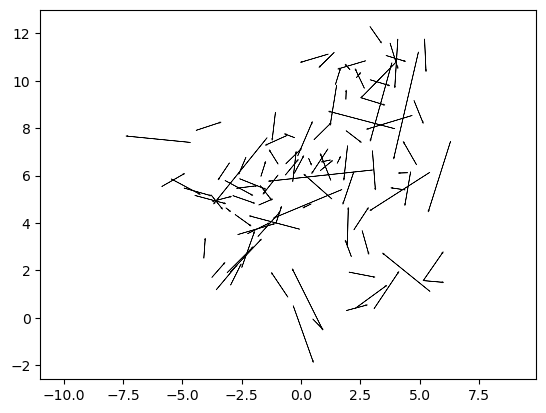

In [49]:
dxsav=np.mean(dx_clusters_smooth,axis=0)
ascale=4.0
ax=plt.gca()
for ic in range(n_clusters):
    ax.arrow(x_clusters[ic,0],x_clusters[ic,1],ascale*dxsav[ic,0],ascale*dxsav[ic,1],head_width=.05,linewidth=.5,color='black',alpha=1.0)

plt.axis('equal')
plt.savefig(date+'/dx_clusters_'+figid+'.png')
plt.savefig(date+'/dx_clusters_'+figid+'.pdf')
plt.pause(.1)

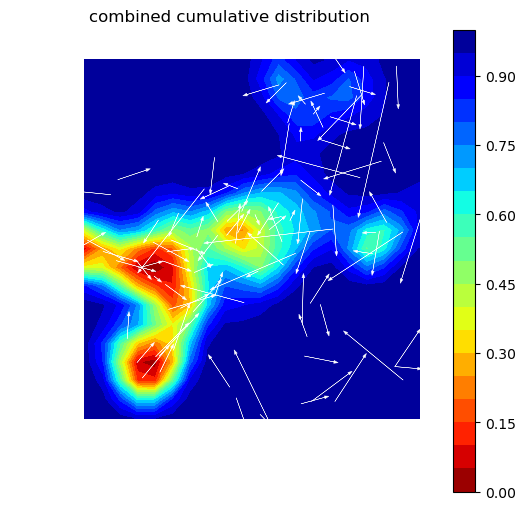

In [50]:
plt.close('all')
nbins=20
fl=0
fu=modelSet[0].nt #frames for time window
sml=1
plt.figure(figsize=(6,6))
indstw=np.where(np.logical_and(indframes_traj<fu,indframes_traj>fl))[0]
prob1,xedges1,yedges1=np.histogram2d(x_clusters_all[indstw,0],x_clusters_all[indstw,1],bins=nbins,density=True)
prob1=scipy.ndimage.gaussian_filter(prob1,sigma=sml)
prob1c=utilities.get_cdist2d(prob1)
xx,yy=np.meshgrid(.5*xedges1[1:]+.5*xedges1[0:-1],.5*yedges1[1:]+.5*yedges1[0:-1])
levels=np.linspace(0,1,21)
cs=plt.contourf(xx,yy,prob1c.T,levels=levels,cmap=plt.cm.jet_r)
cbar=utilities.colorbar(cs)
#cbar.set_label('cumulative probability')
plt.title('combined cumulative distribution')
plt.axis('off')
for ic in range(n_clusters):
    ax=plt.gca()
    ax.arrow(x_clusters[ic,0],x_clusters[ic,1],ascale*dxsav[ic,0],ascale*dxsav[ic,1],head_width=.1,linewidth=.3,color='white',alpha=1.0)

plt.savefig(date+'/probflows_'+figid+'.png')
plt.savefig(date+'/probflows_'+figid+'.pdf')
plt.pause(.1)

In [ ]:
dx_traj

/tmp/ipykernel_268057/1832027526.py:21: RuntimeWarning: invalid value encountered in divide
  vdist1=np.divide(vdist1,norm1)


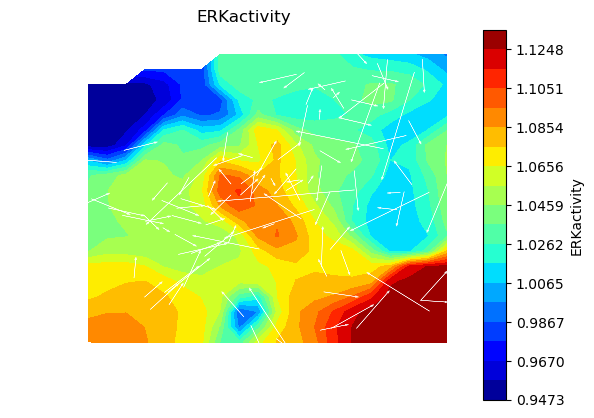

/tmp/ipykernel_268057/1832027526.py:21: RuntimeWarning: invalid value encountered in divide
  vdist1=np.divide(vdist1,norm1)


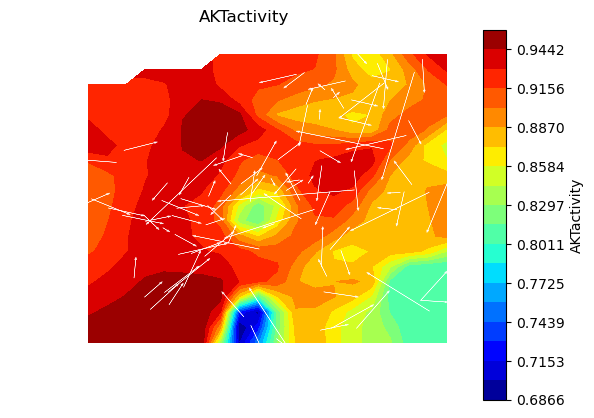

/tmp/ipykernel_268057/1832027526.py:21: RuntimeWarning: invalid value encountered in divide
  vdist1=np.divide(vdist1,norm1)


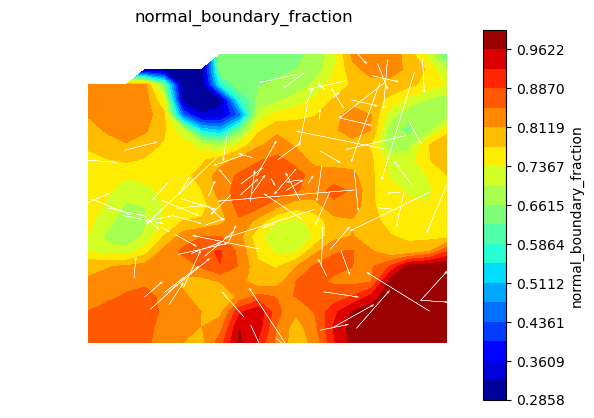

/tmp/ipykernel_268057/1832027526.py:21: RuntimeWarning: invalid value encountered in divide
  vdist1=np.divide(vdist1,norm1)


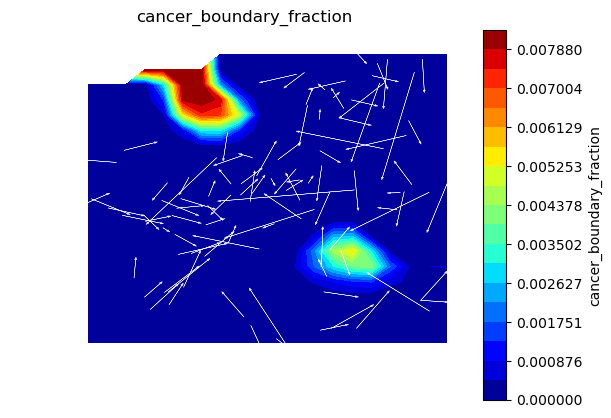

/tmp/ipykernel_268057/1832027526.py:21: RuntimeWarning: invalid value encountered in divide
  vdist1=np.divide(vdist1,norm1)


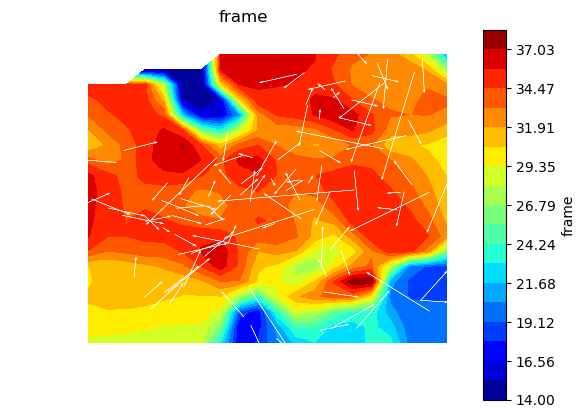

/tmp/ipykernel_268057/1832027526.py:21: RuntimeWarning: invalid value encountered in divide
  vdist1=np.divide(vdist1,norm1)


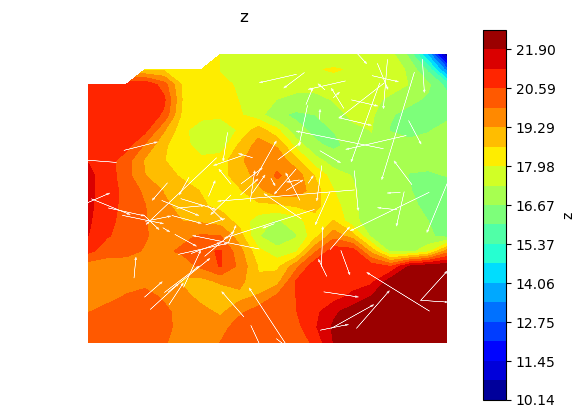

/tmp/ipykernel_268057/1832027526.py:21: RuntimeWarning: invalid value encountered in divide
  vdist1=np.divide(vdist1,norm1)


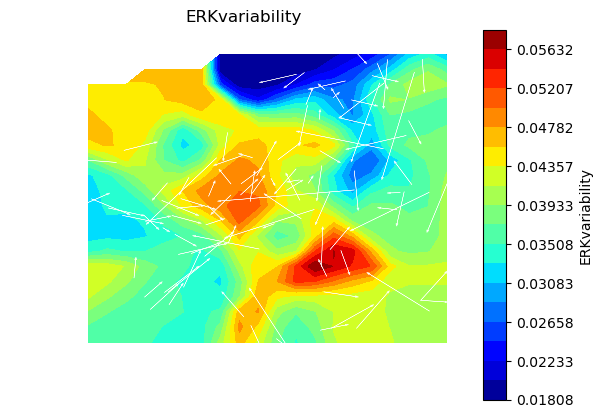

/tmp/ipykernel_268057/1832027526.py:21: RuntimeWarning: invalid value encountered in divide
  vdist1=np.divide(vdist1,norm1)


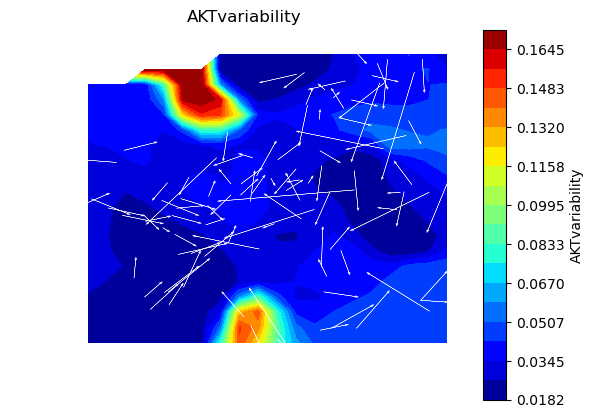

/tmp/ipykernel_268057/1832027526.py:21: RuntimeWarning: invalid value encountered in divide
  vdist1=np.divide(vdist1,norm1)


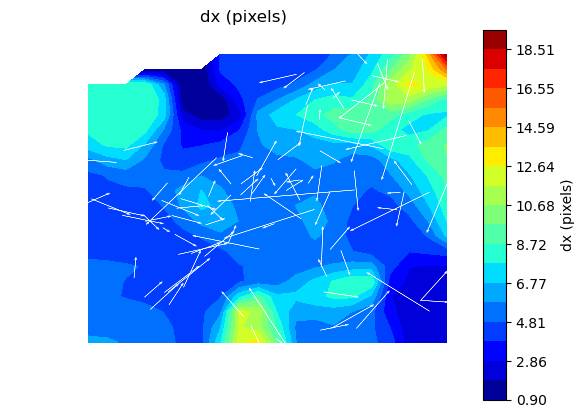

In [51]:
corrc_erk_var_traj=np.std(corrc_erk_full_traj,axis=1)
corrc_akt_var_traj=np.std(corrc_akt_full_traj,axis=1)
#vsetList=[corrc_traj,cb_ratio_traj-cbc_ratio_traj,cbc_ratio_traj,indframes_traj,z_traj,corrc_var_traj,dx_traj]
#captionset=['ERKactivity','normal_boundary_fraction','cancer_boundary_fraction','frame','z','ERKvariability','dx (pixels)']
vsetList=[corrc_erk_traj,corrc_akt_traj,cb_ratio_traj-cbc_ratio_traj,cbc_ratio_traj,indframes_traj,z_traj,corrc_erk_var_traj,corrc_akt_var_traj,dx_traj]
captionset=['ERKactivity','AKTactivity','normal_boundary_fraction','cancer_boundary_fraction','frame','z','ERKvariability','AKTvariability','dx (pixels)']
#vset=cb_ratio_traj
#vset=cc_ratio_traj
#vset=Xpcat[:,-3]
nf=len(tmSet)
nbins=20
for iv in range(len(vsetList)):
    vset=vsetList[iv]
    indg=np.where(np.logical_and(np.logical_not(np.isnan(vset)),np.logical_not(np.isinf(vset))))[0]
    plt.figure()
    #plt.subplot(4,4,1)
    vdist1,xedges1,yedges1=np.histogram2d(x_clusters_all[indg,0],x_clusters_all[indg,1],bins=nbins,weights=vset[indg])
    vdist1=scipy.ndimage.gaussian_filter(vdist1,sigma=sml)
    norm1,xedges1,yedges1=np.histogram2d(x_clusters_all[indg,0],x_clusters_all[indg,1],bins=[xedges1,yedges1])
    norm1=scipy.ndimage.gaussian_filter(norm1,sigma=sml)
    vdist1=np.divide(vdist1,norm1)
    indnan=np.where(np.isnan(vdist1))
    indgood=np.where(np.logical_and(np.logical_not(np.isnan(vdist1)),np.logical_not(np.isinf(vdist1))))
    xedges1c=.5*(xedges1[1:]+xedges1[0:-1])
    yedges1c=.5*(yedges1[1:]+yedges1[0:-1])
    xx,yy=np.meshgrid(xedges1c,yedges1c)
    levels=np.linspace(np.min(vdist1[indgood]),np.max(vdist1[indgood]),20)
    cs=plt.contourf(xx,yy,vdist1.T,cmap=plt.cm.jet,levels=levels)
    for ic in range(n_clusters):
        ax=plt.gca()
        ax.arrow(x_clusters[ic,0],x_clusters[ic,1],ascale*dxsav[ic,0],ascale*dxsav[ic,1],head_width=.07,linewidth=.3,color='white',alpha=1.0)
    cs.cmap.set_over('darkred')
    cs.cmap.set_under('darkblue')
    cbar=utilities.colorbar(cs)
    cbar.set_label(captionset[iv])
    #cbar.set_label('cell-cell boundary fraction')
    #cbar.set_label('speed')
    #cbar.set_label('beta')
    plt.title(captionset[iv])
    plt.axis('off')
    plt.savefig(date+'/'+captionset[iv]+'_wflows_comb_'+figid+'.png')
    plt.savefig(date+'/'+captionset[iv]+'_wflows_comb_'+figid+'.pdf')
    plt.pause(.4)

In [ ]:
plt.close('all')
plt.clf()
nstateSet=[2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,18,20,22,24,28,30] #,30,40]
nS=len(nstateSet)
scoreSet_states=[None]*nS
nstates_initial=nstateSet[0]
pcut_final=.015
indc_x0set=clusters_minima.assign(x0set);indc_x1set=clusters_minima.assign(x1set)
for istate in range(len(nstateSet)):
    MtSet_test=[None]*nf
    nstates=nstateSet[istate]
    scoreSet=np.zeros(nf)
    #clusters_v = KMeans(n_clusters=nstates,init='k-means++',n_init=1000,max_iter=1000)
    #clusters_v.fit(vkin)
    #states=clusters_v.labels_
    states,nstates_initial=model.get_kineticstates(vkin,nstates,nstates_initial=nstates_initial,pcut_final=pcut_final,seed=0,return_nstates_initial=True,cluster_ninit=100)
    for imf in range(nf):
        print('building likelihood model for '+tmSet[imf])
        indmodels=np.where(inds_tmSet_models==imf)[0]
        indmodels=np.intersect1d(indmodels,indgood_models)
        indstm=np.array([]).astype(int)
        for i in indmodels: #[:-1]:
            indstm=np.append(indstm,np.where(inds_trajsteps_models==i)[0])
        MtSet_test[imf]=model.get_transition_matrix_CG(x0set[indstm,:],x1set[indstm,:],clusters=clusters_minima,states=states)
        #scoreSet[imf]=model.get_kscore(MtSet_test[imf])
        scoreSet[imf]=model.get_path_entropy_2point(states[indc_x0set],states[indc_x1set],MtSet_test[imf])
    print(str(nstates)+' states')
    print(scoreSet)
    nstates_initial=nstates_initial+1
    #np.savetxt(f'{date}_scoreSet_{figid}_nS{nstates}.dat',scoreSet)
    scoreSet_states[istate]=scoreSet
    plt.clf()
    plt.contourf(xx,yy,-np.log(prob1.T),cmap=plt.cm.gray,alpha=0.8)
    plt.scatter(x_clusters[:,0],x_clusters[:,1],s=100,c=states,cmap=plt.cm.jet)
    plt.title(str(nstates))
    plt.pause(2)
    #plt.savefig(f'{date}/clustertest_{figid}_{nstates}.png')

In [ ]:
scoreSet_statearray=np.zeros((nS,nf))
for istate in range(len(nstateSet)):
    try:
        scoreSet_statearray[istate,:]=scoreSet_states[istate]
    except:
        pass

plt.close('all')
#colorSet=['red','gold','green','blue','black','red','gold','green','blue','black','brown','orange','purple']
colorSet=['blue','red','gold','black','purple','green','orange','brown','cyan','lightgreen','magenta','darkblue','darkred','darkgray','darkgreen']
plt.clf()
for imf in range(nf):
    plt.plot(nstateSet,scoreSet_statearray[:,imf],'o-',color=colorSet[imf],label=tmSet[imf],alpha=.2)

plt.plot(nstateSet,np.nanmean(scoreSet_statearray,axis=1),'o--',color='black',linewidth=2)
plt.yscale('log')
plt.ylabel(r'path entropy $-\langle log(p_{ij})\rangle$')
#plt.ylabel(r'kinetic score ($\sum_l \tau_l$)')
plt.xlabel('number of states');plt.pause(.1)
plt.savefig(f'{date}/entropyset_{figid}.png')

In [ ]:
scoreSet

In [ ]:
get_kstates=True
nstates_final=18
#nstates_final=13 #for production
pcut_final=.015 #for prediction
#pcut_final=.02 #for production
nstates_initial=nstates_final
stateCenters=x_clusters
if get_kstates:
    stateSet=model.get_kineticstates(vkin,nstates_final,nstates_initial=nstates_initial,pcut_final=pcut_final,seed=0,return_nstates_initial=False,cluster_ninit=100)
    objFile='stateSet_'+figid+'_nS'+str(nstates)+'.obj'
    objFileHandler=open(objFile,'wb')
    states_object=[clusters_minima,stateSet]
    pickle.dump(states_object,objFileHandler,protocol=4)
    objFileHandler.close()
    #stateSet=get_kineticstates(wctm,nstates_final,P=MtSet[4],clusters_minima=clusters_minima,pcut_final=.01,ncomp=ncomp) #treatment specific
else:
    objFile='stateSet_'+figid+'_nS'+str(nstates_final)+'.obj'
    objFileHandler=open(objFile,'rb')
    states_object=pickle.load(objFileHandler)
    clusters_minima=states_object[0]
    stateSet=states_object[1]
    objFileHandler.close()

nstates=np.unique(stateSet).size; n_states=nstates
state_centers_minima=np.zeros((n_states,2))
for i in range(n_states):
    indstate=np.where(stateSet==i)[0]
    state_centers_minima[i,:]=np.median(stateCenters[indstate,:],axis=0)



In [ ]:
state_order=np.argsort(state_centers_minima[:,0])
#state_order=np.array([9,16,15,13,10,4,6,7,3,14,12,11,1,0,2,5,8]).astype(int)
#state_order=np.array([0,1,2,7,18,17,15,4,11,8,3,14,16,12,13,5,6,9,10])
#state_order=np.array([0,2,1,7,18,17,15,8,11,4,3,16,14,5,12,13,6,9,10])
stateSet_ordered=np.ones_like(stateSet)*-1
for istate in range(nstates):
    stateSet_ordered[stateSet==state_order[istate]]=istate

stateSet=stateSet_ordered

nstates=np.unique(stateSet).size; n_states=nstates
state_centers_minima=np.zeros((n_states,2))
for i in range(n_states):
    indstate=np.where(stateSet==i)[0]
    state_centers_minima[i,:]=np.median(stateCenters[indstate,:],axis=0)

inds_states=[None]*n_states
for i in range(n_states):
    indstate=np.where(stateSet[ind_clusters]==i)[0]
    inds_states[i]=indstate

In [ ]:
import string
nbins=prob1.shape[0]
state_labels=np.array(list(string.ascii_uppercase))[0:nstates]
plt.close('all');plt.figure(figsize=(6,5))
plt.clf()
pts=np.array([xx.flatten(),yy.flatten()]).T
#indpts=clusters_minima.assign(pts)
#states=stateSet[indpts]
#states=states[prob1.flatten()>np.min(prob1[prob1>0])]
#pts=pts[prob1.flatten()>np.min(prob1[prob1>0]),:]
plt.contourf(xx,yy,prob1.T,cmap=plt.cm.gray,levels=20,alpha=.3)
#plt.scatter(tateSet=model.get_kineticstates(vkin,nstates_final,nstates_initial=nstates_initial,pcut_final=pcut_final,seed=0,return_nstates_initial=False,cluster_ninit=500)ts[:,0],pts[:,1],s=10,c=states,cmap=plt.cm.jet,marker='.',alpha=0.5)
plt.scatter(x_clusters[:,0],x_clusters[:,1],s=100,c=stateSet,cmap=plt.cm.jet)
#for ic in range(n_clusters):
#    ax=plt.gca()
#    ax.arrow(x_clusters[ic,0],x_clusters[ic,1],dxsav[ic,0],dxsav[ic,1],head_width=.1,linewidth=.2,color='white',alpha=1.0)

for istate in range(nstates):
    plt.text(state_centers_minima[istate,0],state_centers_minima[istate,1],str(state_labels[istate]))


plt.savefig(date+'/kineticstates_'+figid+'_nS_'+str(nstates)+'.png')
plt.savefig(date+'/kineticstates_'+figid+'_nS_'+str(nstates)+'.pdf')
plt.pause(.1)

In [ ]:
def show_cell_activation(self,icell,cyto_msk_channel=0,nuc_msk_channel=1,rep_img_channel=3,nuc_img_channel=0,bf_img_channel=4,viewsize=50,npix=100,sigma=3.,zoom=2,nuchigh=None,nuclow=None,rephigh=None,replow=None,bflow=None,bfhigh=None,projection=False):
    #plt.figure(figsize=(6,6))
    try:
        imgc,mskc=self.get_cell_data(icell,relabel_mskchannels=[0,1],boundary_expansion=[1,viewsize,viewsize])
        imgc2,mskc2=self.get_cell_data(icell,relabel_mskchannels=[],boundary_expansion=[1,viewsize,viewsize])
        if not projection:
            mslices=np.where(np.sum(mskc[...,cyto_msk_channel],axis=(1,2))>0)[0]
            hslice=np.argmax(np.sum(imgc[mslices,:,:,nuc_img_channel],axis=(1,2)))
            islice=mslices[hslice]
            img_rep=imprep.znorm(imgc[islice,:,:,rep_img_channel]).astype(float)
            #img_rep=imprep.znorm(np.max(imgc[...,rep_img_channel],axis=0))
            img_nuc=imprep.znorm(imgc[islice,:,:,nuc_img_channel]).astype(float)
            #img_nuc=imprep.znorm(np.max(imgc[...,nuc_img_channel],axis=0))
            img_bf=skimage.filters.difference_of_gaussians(imgc[...,bf_img_channel],.5,1.5)
            img_bf=imprep.znorm(img_bf[islice,:,:]).astype(float)
            #img_bf=imprep.znorm(np.max(img_bf,axis=0))
            msk_cyto=mskc[islice,:,:,cyto_msk_channel]
            #msk_cyto=np.max(mskc[...,cyto_msk_channel],axis=0)
            msk2_cyto=mskc2[islice,:,:,cyto_msk_channel]
            msk_nuc=mskc[islice,:,:,nuc_msk_channel]
            #msk_nuc=np.max(mskc[...,nuc_msk_channel],axis=0)
            msk_f=mskc[islice,:,:,self.fmskchannel]
            #msk_f=np.max(mskc[...,self.fmskchannel],axis=0)
        else:
            img_rep=np.max(imprep.znorm(imgc[:,:,:,rep_img_channel]).astype(float),axis=0)
            img_nuc=np.max(imprep.znorm(imgc[:,:,:,nuc_img_channel]).astype(float),axis=0)
            img_bf=skimage.filters.difference_of_gaussians(imgc[...,bf_img_channel],.5,1.5)
            img_bf=np.max(imprep.znorm(img_bf[:,:,:]).astype(float),axis=0)
            msk_cyto=np.max(mskc[:,:,:,cyto_msk_channel],axis=0)
            msk2_cyto=np.max(mskc2[:,:,:,cyto_msk_channel],axis=0)
            msk_nuc=np.max(mskc[:,:,:,nuc_msk_channel],axis=0)
            msk_f=np.max(mskc[:,:,:,self.fmskchannel],axis=0)
        if nuchigh is None:
            nuclow=np.percentile(img_nuc,5);nuchigh=np.percentile(img_nuc,95)
        img_nuc[msk_nuc==0]=-1000.
        #img_rep[msk_cyto==0]=-1000.1
        img_bf=np.abs(img_bf)
        #img_bf[np.logical_not(msk_f)]=0
        img_rep=scipy.ndimage.zoom(img_rep,zoom,order=1)
        img_rep=scipy.ndimage.gaussian_filter(img_rep,sigma)
        img_nuc=scipy.ndimage.zoom(img_nuc,zoom,order=1)
        img_nuc=scipy.ndimage.gaussian_filter(img_nuc,sigma)
        img_bf=scipy.ndimage.zoom(img_bf,zoom,order=1)
        if rephigh is None:
            replow=np.percentile(img_rep,5);rephigh=np.percentile(img_rep,95)
        if bfhigh is None:
            bflow=np.percentile(img_bf,5);bfhigh=np.percentile(img_bf,95)
        #img_bf=scipy.ndimage.gaussian_filter(img_bf,sigma)
        msk_f=scipy.ndimage.zoom(msk_f,zoom,order=1)
        msk_cyto=scipy.ndimage.zoom(msk_cyto,zoom,order=1)
        msk2_cyto=scipy.ndimage.zoom(msk2_cyto,zoom,order=1)
        plt.imshow(img_bf,cmap=plt.cm.binary,clim=(bflow,bfhigh),alpha=1.)
        #csr=plt.contour(img_rep,levels=np.linspace(rep_min,rep_max,201),cmap=plt.cm.binary,extend='both')
        #csr.cmap.set_over('black')
        #csr.cmap.set_under('white')
        plt.imshow(np.ma.masked_where(msk_cyto==0,img_rep),cmap=plt.cm.inferno,alpha=.7)
        #####plt.imshow(img_rep,cmap=plt.cm.YlOrBr,clim=(replow,3*rephigh),alpha=.3)
        #plt.contour(img_rep,levels=np.linspace(0,10,11),cmap=plt.cm.inferno,alpha=.3)
        csn=plt.contour(img_nuc,levels=np.linspace(nuclow,nuchigh,4),cmap=plt.cm.Reds,alpha=0.6,linewidths=1)
        #####csn=plt.contour(msk2_cyto>0,levels=np.unique(msk_cyto>0),colors='orange',linewidths=1.2,alpha=.4)
        csn=plt.contour(msk_cyto>0,levels=np.unique(msk_cyto>0),colors='darkorange',linewidths=2)
        csn.cmap.set_over('darkred')
        csn.cmap.set_under('white')
        #cs.cmap.set_under('white')
        plt.imshow(np.ma.masked_where(msk_f==0,np.ones_like(msk_f)),cmap=plt.cm.binary_r,clim=(0,1),alpha=0.15)
        #plt.xlim(viewsize*zoom/2-1*viewsize*zoom,viewsize*zoom/2+1*viewsize*zoom)
        #plt.ylim(viewsize*zoom/2-1*viewsize*zoom,viewsize*zoom/2+1.3*viewsize*zoom)
        #plt.text(zoom*npix/2,zoom*npix/4,r'central slice \textbf{YFP} \textcolor{red}{\textbf{Cy5}}')
        #plt.text(zoom*npix/2,zoom*npix/4,'central slice, YFP black, Cy5 red')
        plt.axis('off')
        return 0
    except Exception as e:
        print(e)
        return 1

In [ ]:
nrounds=1
nr=1
maxl=trajl
stordir='cellstatepics'
os.system(f'mkdir -p {date}/{stordir}')
nuclow=-1.;nuchigh=9.;replow=0.;rephigh=5.;bflow=0.;bfhigh=5.
npics=4
for iround in range(nrounds):
    plt.close('all')
    for istate in range(nstates):
        indcells_traj=inds_states[istate]
        indmodels=indtreatment_traj[indcells_traj]
        indcells_model=cellinds1_traj[indcells_traj]
        indr=np.random.choice(indcells_model.size,nr,replace=False)
        for ic in indr: #range(indcells_traj.size):
            plt.figure(figsize=(12,4))
            model_sctm=modelSet[indmodels[ic]]
            celltraj=model_sctm.get_cell_trajectory(indcells_model[ic])
            if celltraj.size>maxl:
                celltraj=celltraj[-maxl:]
            iplot=0
            for icell in np.linspace(0,celltraj.size-1,npics).astype(int):
                indcell=celltraj[icell]
                plt.subplot(1,npics+1,iplot+1)
                show_cell_activation(model_sctm,indcell,nuclow=nuclow,nuchigh=nuchigh,replow=replow,rephigh=rephigh,bflow=bflow,bfhigh=bfhigh)
                iplot=iplot+1
                plt.title(f'state {state_labels[istate]}')
            plt.savefig(f'{date}/{stordir}/state{state_labels[istate]}_cell{ic}_model{indmodels[ic]}_{figid}.png')
            plt.pause(.1)

In [ ]:
MtSet=[None]*nf
MtSetCG=[None]*nf
for imf in range(nf):
    print('building likelihood model for '+tmSet[imf])
    indmodels=np.where(inds_tmSet_models==imf)[0]
    indmodels=np.intersect1d(indmodels,indgood_models)
    indstm=np.array([]).astype(int)
    for i in indmodels: #[:-1]:
        indstm=np.append(indstm,np.where(inds_trajsteps_models==i)[0])
    MtSet[imf]=model.get_transition_matrix(x0set[indstm,:],x1set[indstm,:],clusters=clusters_minima);
    MtSetCG[imf]=model.get_transition_matrix_CG(x0set[indstm,:],x1set[indstm,:],clusters=clusters_minima,states=stateSet);

In [ ]:
nf=1
state_probs=np.zeros((nf,n_states))
nwindow=25
ntimes=12
state_probs_times=np.zeros((nf,n_states,ntimes+1))
itimes=0
for itt in range(nwindow,modelSet[0].nt,ntimes):
    fl=itt-nwindow
    fu=itt+nwindow
    indstw=np.where(np.logical_and(indframes_traj<fu,indframes_traj>fl))[0]
    for i in range(nf):
        indstm=inds_conditions[i]
        indstwm=np.intersect1d(indstm,indstw)
        x0=x[indstwm,:]
        indc0=stateSet[clusters_minima.assign(x0)]
        statesc,counts=np.unique(indc0,return_counts=True)
        state_probs[i,statesc]=counts/np.sum(counts)
    state_probs_times[:,:,itimes]=state_probs
    itimes=itimes+1

In [ ]:
plt.clf()
plt.imshow(state_probs_times[0,:,:].T,origin='lower',cmap=plt.cm.gnuplot)
ax=plt.gca()
ax.set_yticks(np.arange(ntimes+1))
ax.set_xticks(np.arange(nstates))
ax.set_xticklabels(np.array(state_labels)[state_order])
ax.set_yticklabels(np.arange(nwindow,modelSet[0].nt,ntimes))
plt.xlabel('state');plt.ylabel('frame')
cbar=plt.colorbar()
cbar.set_label('state probabilities')
plt.savefig(date+f'/stateprobs_times_{figid}_nS{n_states}.png')
plt.pause(.1);

In [ ]:
plt.clf()
plt.imshow(state_probs_times[0,:,:].T,origin='lower',cmap=plt.cm.gnuplot)
ax=plt.gca()
ax.set_yticks(np.arange(ntimes+1))
ax.set_xticks(np.arange(nstates))
ax.set_xticklabels(np.array(state_labels)[state_order])
ax.set_yticklabels(np.arange(nwindow,modelSet[0].nt,ntimes))

In [ ]:
nstates

In [ ]:
fl=0
fu=180
cell_states=clusters_minima
indstw=np.where(np.logical_and(indframes_traj<fu,indframes_traj>fl))[0]
for i in range(nf):
    indstm=inds_conditions[i]
    indstwm=np.intersect1d(indstm,indstw)
    x0=x[indstwm,:]
    indc0=stateSet[clusters_minima.assign(x0)]
    statesc,counts=np.unique(indc0,return_counts=True)
    state_probs[i,statesc]=counts/np.sum(counts)

np.savetxt(f'{date}/stateprobs_'+figid+'_nS'+str(nstates)+'.dat',state_probs)

In [ ]:
plt.clf()
plt.close('all')
vsetList=[corrc_erk_traj,corrc_akt_traj,cb_ratio_traj,imprep.znorm(cb_ratio_traj-cbc_ratio_traj),cbc_ratio_traj,indframes_traj,z_traj,corrc_erk_var_traj,dx_traj]
captionset=['ERKactivity','AKTactivity','boundary_fraction','normal_boundary_fractionz','cancer_boundary_fraction','frame','z','ERKvariability','dx']
for iv in range(len(vsetList)):
    vset=vsetList[iv]
    plt.figure(figsize=(10,4))
    ax=plt.gca()
    for i in range(n_states):
        setv=vset[inds_states[i]]
        setv=setv[np.isfinite(setv)]
        vplot=ax.violinplot(setv,positions=[i+1],showmeans=True,showextrema=False) #,quantiles=[.05,.95])
        vplot['cmeans'].set_color('black')
        for pc in vplot['bodies']:
            pc.set_facecolor('black')
            #pc.set_edgecolor('black')
            #pc.set_alpha(1)
    ax.set_xticks(range(1,n_states+1))
    ax.set_xticklabels(state_labels)
    #plt.ylabel('log2(nuc/cyto cc-ratio)')
    #plt.ylabel(r'cell-cell local alignment $\langle \hat{v}_1 \cdot \hat{v}_2 \rangle$')
    #plt.ylabel('speed (z-score)')
    #plt.ylabel('nuc/cyt cc-ratio')
    plt.ylabel(captionset[iv])
    plt.xlabel('states')
    #plt.savefig(date+'/'+captionSet[iv]+'_tearplot_'+figid+'.png')
    plt.savefig(date+'/'+captionset[iv]+'_tearplot_'+figid+'.pdf')
    plt.pause(.5)


In [ ]:
plt.figure(figsize=(15,12))
frames=np.arange(trajl)
cb_ratio_full_traj=imprep.znorm(cb_ratio_full_traj-cbc_ratio_full_traj)
cbc_ratio_full_traj=imprep.znorm(cbc_ratio_full_traj)
corrc_full_traj=imprep.znorm(corrc_erk_full_traj)
dx_full_traj=imprep.znorm(dx_full_traj)
hplots=5;vplots=5;
for istate in range(nstates):
    plt.subplot(vplots,hplots,istate+1)
    ax=plt.gca()
    plt.plot(frames,np.mean(cb_ratio_full_traj[inds_states[istate],:],axis=0),color='blue',alpha=.25,linewidth=3,label='fraction neighbors')
    ulim=np.percentile(cb_ratio_full_traj[inds_states[istate],:],75,axis=0)
    llim=np.percentile(cb_ratio_full_traj[inds_states[istate],:],25,axis=0)
    #ax.fill_between(frames,llim,ulim,color='blue',alpha=.3)
    plt.plot(frames,np.mean(cbc_ratio_full_traj[inds_states[istate],:],axis=0),color='red',alpha=.25,linewidth=3,label='fraction cancer neighbors')
    ulim=np.percentile(cbc_ratio_full_traj[inds_states[istate],:],75,axis=0)
    llim=np.percentile(cbc_ratio_full_traj[inds_states[istate],:],25,axis=0)
    plt.plot(frames,np.nanmean(dx_full_traj[inds_states[istate],:],axis=0),color='green',alpha=.25,linewidth=3,label='motility')
    plt.plot(frames,np.mean(corrc_full_traj[inds_states[istate],:],axis=0),color='goldenrod',linewidth=3,label='ERK activity')
    ulim=np.percentile(corrc_full_traj[inds_states[istate],:],75,axis=0)
    llim=np.percentile(corrc_full_traj[inds_states[istate],:],25,axis=0)
    ax.fill_between(frames,llim,ulim,color='goldenrod',alpha=.3)
    plt.ylim(-2.8,2);
    plt.xlim(0,trajl)
    plt.text(0,1.7,f'state {state_labels[istate]}')
    if (istate+1)%hplots==1:
        plt.ylabel('z-score')
    if istate+1>(hplots*(hplots-1)):
        plt.xlabel('frame')
    if istate+1==nstates:
        plt.subplot(vplots,hplots,istate+2)
        plt.plot(frames,np.mean(dx_full_traj[inds_states[istate],:],axis=0),color='green',alpha=.25,linewidth=3,label='motility')
        plt.plot(frames,np.mean(cb_ratio_full_traj[inds_states[istate],:],axis=0),color='blue',alpha=.25,linewidth=3,label='fraction neighbors')
        plt.plot(frames,np.mean(cbc_ratio_full_traj[inds_states[istate],:],axis=0),color='red',alpha=.25,linewidth=3,label='fraction cancer neighbors')
        plt.plot(frames,np.mean(corrc_full_traj[inds_states[istate],:],axis=0),color='goldenrod',linewidth=3,label='ERK activity')
        plt.xlim(-100,0)
        plt.legend(loc='lower right')
        plt.axis('off')

plt.savefig(date+'/signaling_neighbors_'+figid+'.png')
plt.savefig(date+'/signaling_neighbors_'+figid+'.pdf')
plt.pause(.1)

In [ ]:
pcut=.01
fcut=.001
rad=.3
mscale=2200
arrowstyle='->'
lws=200.
sh=8
state_centers=state_centers_minima
fl=0
fu=180
indstw_all=np.where(np.logical_and(indframes_traj<fu,indframes_traj>fl))[0]
xmin=np.min(x_clusters[:,0])
xmax=np.max(x_clusters[:,0])
ymin=np.min(x_clusters[:,1])
ymax=np.max(x_clusters[:,1])
#MtSet=[None]*nf
plt.figure(figsize=(6,6))
for i in [0]: #range(nf):
    #plt.subplot(4,4,i+2)
    indmodels=np.where(inds_tmSet_models==i)[0]
    indstm=np.array([]).astype(int)
    for imodel in indmodels:
        indstm=np.append(indstm,np.where(inds_trajsteps_models==imodel)[0].astype(int))
    x0=x0set[indstm,:]
    x1=x1set[indstm,:]
    Mt=model.get_transition_matrix_CG(x0,x1,clusters_minima,stateSet)
    #MtSet[i]=Mt.copy()
    #Mt=MtSet[i]
    ax=plt.gca()
    for j in range(n_states):
        for k in range(n_states):
            fluxjk=state_probs[i,j]*Mt[j,k]
            fluxkj=state_probs[i,j]*Mt[k,j]
            flux=fluxjk-fluxkj
            if j<k and flux>fcut and state_probs[i,j]>pcut: #Mt[j,k]>pcut:
                arrow = matplotlib.patches.FancyArrowPatch((state_centers[j,0], state_centers[j,1]), (state_centers[k,0], state_centers[k,1]),shrinkA=sh,shrinkB=sh,mutation_scale=mscale*flux,color='black',arrowstyle=arrowstyle,connectionstyle='arc3,rad='+str(rad),lw=lws*flux,joinstyle='miter',capstyle='butt') #note j and k flipped because drawing arrow at tail
                ax.add_patch(arrow)
            if j>k and flux>fcut and state_probs[i,j]>pcut: #Mt[j,k]>pcut:
                arrow = matplotlib.patches.FancyArrowPatch((state_centers[j,0], state_centers[j,1]), (state_centers[k,0], state_centers[k,1]),shrinkA=sh,shrinkB=sh,mutation_scale=mscale*flux,color='black',arrowstyle=arrowstyle,connectionstyle='arc3,rad='+str(rad),lw=lws*flux,joinstyle='miter',capstyle='butt')
                ax.add_patch(arrow)
        plt.text(state_centers[j,0],state_centers[j,1],state_labels[j],color='black',ma='center')
    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax+.5)
    plt.axis('off')
    plt.title(tmSet[i])

plt.savefig(date+'/networkflux_'+figid+'_nS'+str(nstates)+'.png')
plt.savefig(date+'/networkflux_'+figid+'_nS'+str(nstates)+'.pdf')
plt.pause(.1)

In [ ]:
pcut=.05
fcut=0.
rad=.3
mscale=40.
arrowstyle='->'
lws=10.
sh=2
state_centers=state_centers_minima
commsize=100
xmin=np.min(x_clusters[:,0])
xmax=np.max(x_clusters[:,0])
ymin=np.min(x_clusters[:,1])
ymax=np.max(x_clusters[:,1])
plt.figure(figsize=(7.5,6))
stateA=[3]; stateB=[9]
indSource=np.array([]).astype(int)
for isource in stateA:
    inds=np.where(stateSet==isource)[0]
    indSource=np.append(indSource,inds)

indTargets=np.array([]).astype(int)
for itargets in stateB:
    inds=np.where(stateSet==itargets)[0]
    indTargets=np.append(indTargets,inds)

for i in range(nf):
    #plt.subplot(4,4,i+2)
    plt.clf()
    Tmatrix=MtSet[i]
    indNotTargets=np.setdiff1d(range(Tmatrix.shape[0]),indTargets)
    indNotSource=np.setdiff1d(range(Tmatrix.shape[0]),indSource)
    prob=prob1
    levels=np.linspace(np.min(prob[prob>0]),np.max(prob),20)
    #plt.contourf(xx,yy,prob.T,levels=levels,cmap=plt.cm.gray_r,alpha=0.8)
    q=model.get_committor(Tmatrix,indTargets,indSource,conv=1.e-5)
    #plt.scatter(x_clusters[:,0],x_clusters[:,1],s=100,c=q,cmap=plt.cm.gist_heat,marker='o',vmin=0.,vmax=1.)
    vdist1,xedges1,yedges1=np.histogram2d(x_clusters[:,0],x_clusters[:,1],bins=nbins,weights=q.flatten())
    vdist1=scipy.ndimage.gaussian_filter(vdist1,sigma=sml)
    norm1,xedges1,yedges1=np.histogram2d(x_clusters[:,0],x_clusters[:,1],bins=[xedges1,yedges1])
    norm1=scipy.ndimage.gaussian_filter(norm1,sigma=sml)
    vdist1=np.divide(vdist1,norm1)
    indnan=np.where(np.isnan(vdist1))
    indgood=np.where(np.logical_and(np.logical_not(np.isnan(vdist1)),np.logical_not(np.isinf(vdist1))))
    xedges1c=.5*(xedges1[1:]+xedges1[0:-1])
    yedges1c=.5*(yedges1[1:]+yedges1[0:-1])
    xx1,yy1=np.meshgrid(xedges1c,yedges1c)
    levels=np.linspace(0,1,21) #np.min(vdist1[indgood]),np.max(vdist1[indgood]),20)
    cs=plt.contourf(xx,yy,vdist1.T,cmap=plt.cm.seismic,levels=levels,alpha=0.5)
    cbar=utilities.colorbar(cs)
    cbar.set_label('committor')
    plt.scatter(x_clusters[indTargets,0],x_clusters[indTargets,1],s=200,c='darkred',marker='x')
    plt.scatter(x_clusters[indSource,0],x_clusters[indSource,1],s=200,c='blue',marker='x')
    #pts=np.array([xx1.flatten(),yy1.flatten()]).T
    #indpts=clusters_2d.assign(pts)
    #states=stateSet[indpts]
    #plt.contour(xx,yy,states.reshape(nbins,nbins),levels=np.arange(nstates),colors='black')
    try:
        tpt=msmtools.flux.tpt(MtSetCG[i],stateA,stateB)
        pathways=tpt.pathways()
        paths=pathways[0]
        capacities=pathways[1]
        ax=plt.gca()
        for ipath in range(-1,-len(paths)-1,-1):
            statepath=paths[ipath]
            colorpath=capacities[ipath]/np.sum(capacities)
            for ipath in range(statepath.size-1):
                j=statepath[ipath]
                k=statepath[ipath+1]
                arrow = matplotlib.patches.FancyArrowPatch((state_centers[j,0], state_centers[j,1]), (state_centers[k,0], state_centers[k,1]),shrinkA=sh,shrinkB=sh,mutation_scale=mscale*colorpath,color='black',arrowstyle=arrowstyle,connectionstyle='arc3,rad='+str(rad),lw=lws*colorpath,joinstyle='miter',capstyle='butt',alpha=colorpath) #note j and k flipped because drawing arrow at tail
                ax.add_patch(arrow)
        for j in range(n_states):
            scolor=tpt.committor[j]+.01
            #plt.scatter(state_centers[j,0],state_centers[j,1],s=commsize,c=plt.cm.gist_heat(scolor),alpha=0.3)
            plt.text(state_centers[j,0],state_centers[j,1],state_labels[j],color='black',weight='bold',fontsize=16,ma='center')
        plt.xlim(xmin,xmax)
        plt.ylim(ymin,ymax+.5)
        plt.axis('off')
        plt.title(tmSet[i])
        plt.savefig(f'{date}/pathways_sadtohappy_{figid}_{tmSet[i]}_nS{nstates}.png')
        plt.savefig(f'{date}/pathways_sadtohappy_{figid}_{tmSet[i]}_nS{nstates}.pdf')
        plt.pause(5)
    except:
        pass

q_states=np.zeros(nstates)
for istate in range(nstates):
    indstate=np.where(stateSet==istate)[0]
    q_states[istate]=np.mean(q[indstate,0])

state_order=np.argsort(q_states)

#### KMD

In [ ]:
test_start_frame=142
#testing_models=np.random.choice(indgood_models.size,ntest,replace=False)
testing_models=np.arange(indgood_models.size).astype(int)
#testing_models=np.arange(8).astype(int)
training_models=np.setdiff1d(np.arange(indgood_models.size).astype(int),testing_models)
testing_models=indgood_models[testing_models]
training_models=indgood_models[training_models]
inds_trajset_training=np.array([]).astype(int)
for imodel in training_models:
    indmodel=np.where(inds_trajsteps_models==imodel)[0]
    inds_trajset_training=np.append(inds_trajset_training,indmodel)

inds_trajset_testing=np.array([]).astype(int)
inds_trajset_testing_cellinds=np.array([]).astype(int)
for imodel in testing_models:
    indmodel=np.where(inds_trajsteps_models==imodel)[0]
    cellinds_model=modelSet[imodel].traj[inds_trajsteps[indmodel,1],-1]
    frames_model=modelSet[imodel].cells_frameSet[cellinds_model]
    inds_trajset_training=np.append(inds_trajset_training,indmodel[frames_model<=test_start_frame])
    inds_trajset_testing=np.append(inds_trajset_testing,indmodel[frames_model==test_start_frame])
    inds_trajset_testing_cellinds=np.append(inds_trajset_testing_cellinds,cellinds_model[frames_model==test_start_frame])

ntest_traj=inds_trajset_testing_cellinds.size
test_trajectories=[None]*ntest_traj
for itest in range(ntest_traj):
    indcell=inds_trajset_testing_cellinds[itest]
    imodel=inds_trajsteps_models[inds_trajset_testing[itest]]
    for itraj in range(len(modelSet[imodel].trajectories)):
        if np.sum(np.where(modelSet[imodel].trajectories[itraj]==indcell)[0])>0:
            cell_traj=modelSet[imodel].trajectories[itraj]
            start=np.where(cell_traj==indcell)[0]
            test_trajectories[itest]=cell_traj[start[0]:]

nplots=int(np.ceil(np.sqrt(ntest_traj)))
test_stds=np.zeros(ntest_traj)
ind_obs_pred=modelSet[0].Xpca.shape[1]-1 #ERK was the last one
#plt.clf()
for itraj in range(ntest_traj):
    imodel=inds_trajsteps_models[inds_trajset_testing[itraj]]
    #plt.subplot(nplots,nplots,itraj+1)
    obs_test=modelSet[imodel].Xpca[test_trajectories[itraj],ind_obs_pred]
    test_stds[itraj]=np.std(obs_test)

In [ ]:
feature_list

In [ ]:
def get_primary_frequency(series):
    rtha=np.abs(np.fft.fft(series))
    freq=np.fft.fftfreq(series.size)
    indf=freq>=0
    freq=freq[indf]
    rtha=rtha[indf]
    indsort=np.argsort(freq)
    freq=freq[indsort]
    rtha=rtha[indsort]
    rtha=rtha/np.sum(rtha)
    #mean_freq=np.sum(np.multiply(rtha,freq))
    mfreq=freq[np.argmax(rtha)]
    return mfreq

def average_delays_test(X_pred,trajl):
    test_steps=X_pred.shape[0]
    ncopies=int(X_pred.shape[1]/trajl)
    obs_pred_all=np.ones((ncopies,test_steps+trajl-1,trajl))*np.nan
    for icopy in range(ncopies):
        for itt in range(trajl):
            inds=np.arange(itt,itt+test_steps).astype(int)
            obs_pred_all[icopy,inds,itt]=X_pred[:,itt+icopy*trajl]
    obs_pred=np.nanmean(obs_pred_all,axis=(0,2))[(trajl-1):]
    return obs_pred

def organize_modes(wam):
    nmodes=wam.size
    mode_index=[]
    mode_absj=np.array([]).astype('complex128')
    wam_orig=wam.copy()
    while wam.size>0:
        w=wam[0]
        imode=np.where(wam_orig==w)[0][0]
        modeset=np.array([imode]).astype(int)
        imode_conj=np.where(wam_orig==np.conj(w))[0]
        if imode_conj.size>0 and imode_conj!=imode:
            modeset=np.append(modeset,imode_conj)
        mode_index.append(modeset)
        mode_absj=np.append(mode_absj,complex(np.real(w),np.abs(np.imag(w))))
        inds_leftover=np.setdiff1d(np.arange(wam.size).astype(int),np.arange(modeset.size))
        wam=wam[inds_leftover]
    return mode_index,mode_absj

def load_koopman_fromdict(koopman_dict): #koopman_dict = {"K":K, "M":M, "Xi":Xi, "Lam":Lam, "W":W, "phi_X":phi_X, "V":V}
    K=koopman_dict["K"]; M=koopman_dict["M"]; Xi=koopman_dict["Xi"]; Lam=koopman_dict["Lam"];
    W=koopman_dict["W"]; phi_X=koopman_dict["phi_X"]; V=koopman_dict["V"]
    return K,M,Xi,Lam,W,phi_X,V

In [ ]:
nplot_traj=inds_trajset_testing.size
#inds_plot=np.array([0,1,3,5,6,8,10,11,23,25,26,29,38,41,45,52]).astype(int);nplots=4
inds_plot=np.argsort(test_stds)[-nplot_traj:];nplots=int(np.ceil(np.sqrt(nplot_traj)));
ind_obs_pred=modelSet[0].Xpca.shape[1]-1 #ERK was the last one
ntraining_transitions=inds_trajset_training.size
inds_train=inds_trajset_training
#ntraining_transitions=1500
#inds_train=np.random.choice(inds_trajset_training,ntraining_transitions,replace=False)
inds_train=np.append(inds_train,inds_trajset_testing)
inds_test_starts=np.arange(ntraining_transitions,ntraining_transitions+ntest_traj).astype(int)
X=x0set[inds_train,:]
Y=x1set[inds_train,:]
#apply boundary conditions
#Acut=-2.;Bcut=2.
#indsA_X=np.where(X[:,-1]<Acut)[0]
#indsA_Y=np.where(Y[:,-1]<Acut)[0]
#indsB_X=np.where(X[:,-1]>Bcut)[0]
#indsB_Y=np.where(Y[:,-1]>Bcut)[0]
#Y[indsA_X,:]=1.e6 #anything in A goes to cemetery after one step
#Y[indsB_X,:]=-1.e6 #X[indsB_X,:] #anything in B stays in B
kname=f'koopman_trajl{trajl}_ERKonly1D_ntrain{ntraining_transitions}'
#1D-ification X=X[:,-1][:,np.newaxis]; Y=Y[:,-1][:,np.newaxis]
n_iterations=10
koopman_models=[None]*n_iterations
s=.1
#lamcut=0. #ntraining_transitions+inds_trajset_test.size
#lamcut_M=.9
M=np.eye(X.shape[1])
test_steps=48 #modelSet[0].nt-test_start_frame
test_frames=np.arange(test_start_frame,test_start_frame+test_steps).astype(int)
#nplots=int(np.ceil(np.sqrt(nplot_traj))); inds_plot=np.random.choice(np.arange(ntest_traj).astype(int),nplot_traj,replace=False)
rmse_iters=np.zeros(n_iterations)
corr_iters=np.zeros(n_iterations)
plt.close('all')
fig4=plt.figure(4,figsize=(14,12))
fig1=plt.figure(1,figsize=(14,12))
fig2=plt.figure(2,figsize=(8,6))
fig3=plt.figure(3,figsize=(9.4,4.5))
realcut=-0.05;imagcut=np.pi/16. #np.inf
X_orig=X.copy();Y_orig=Y.copy()
betaM=.001
for i_iter in range(n_iterations):
    M=(1.-betaM)*M+betaM*np.eye(X.shape[1])
    #dmat=scipy.spatial.distance.cdist(np.matmul(X,M),np.matmul(Y,M));plt.figure(3);plt.clf();sigma=get_scaled_sigma(dmat,visual=True);plt.pause(.1);h=np.ones(X.shape[0])*sigma
    XX=np.matlib.repmat(X,1,int(M.shape[1]/X.shape[1]));YY=np.matlib.repmat(Y,1,int(M.shape[1]/Y.shape[1]))
    h=model.get_kernel_sigmas(XX,M,s=s)
    psi_X=model.get_gaussianKernelM(XX,XX,M,h)
    psi_Y=model.get_gaussianKernelM(XX,YY,M,h)
    #K,Xi,Lam,W=model.get_koopman_eig(XX,YY,M=M.astype('float64'),h=h.astype('float64'),psi_X=psi_X.astype('float64'),psi_Y=psi_Y.astype('float64'))
    K,Xi,Lam,W=model.get_koopman_eig(XX,YY,M=M,h=h,psi_X=psi_X,psi_Y=psi_Y)
    wam=np.log(np.diag(Lam))
    lam=np.diag(Lam)
    indmodes=np.where(np.logical_and(np.real(wam)<0.15,np.abs(np.imag(wam))<np.pi/3.))[0]
    #indmodes=np.where(np.logical_and(np.real(wam)<np.inf,np.abs(np.imag(wam))<np.inf))[0]
    if indmodes.size==0:
        indmodes=np.array([0]).astype(int)
    phi_X,V=model.get_koopman_modes(psi_X,Xi[:,indmodes],W[:,indmodes],XX)
    spatial_frequencies=np.zeros(indmodes.size)
    for imode in range(indmodes.size):
        spatial_frequencies[imode]=get_primary_frequency(V[:,imode])
    indspatial=np.where(spatial_frequencies<.1)[0]
    wam_reconstr=wam[indmodes]
    lam_reconstr=lam[indmodes]
    indmodes_M1=np.where(np.logical_and(np.real(wam_reconstr)>realcut,np.abs(np.imag(wam_reconstr))<imagcut))[0];indmodes_M1=np.intersect1d(indmodes_M1,indspatial)
    indmodes_noimaginary=np.where(np.sum(np.abs(np.imag(phi_X)),axis=0)==0.)[0]; indmodes_M2=indmodes_noimaginary[np.logical_and(np.real(wam[indmodes_noimaginary])>realcut,np.abs(np.imag(wam_reconstr[indmodes_noimaginary]))<imagcut)];
    #indmodes_M2=np.array([indmodes_noimaginary[np.argmin(np.abs(lam_reconstr[indmodes_noimaginary]-(1.+0.j)))]]).astype(int)
    #indmodes_M2=np.array([indmodes_noimaginary[np.argmin(np.abs(lam_reconstr[indmodes_noimaginary]-(1.+0.j)))]]).astype(int)
    indmodes_M1=np.setdiff1d(indmodes_M1,indmodes_M2) #indmodes_M=np.array([indmodes_M1[0],indmodes_M2[0]])
    if indmodes_M1.size==0:
        indmodes_M1=np.array([np.setdiff1d(indmodes,indmodes_M2)[0]])
    plt.figure(4);plt.clf()
    for i in range(81):
        imode=indmodes[i];vim=np.zeros((test_steps,XX.shape[1])).astype('complex128');vim[0,:]=V[:,i];nm=48
        for inm in range(1,test_steps):
            vim[inm,:]=vim[inm-1,:]*lam[imode]
        plt.subplot(9,9,i+1);plt.imshow(np.real(vim),cmap=plt.cm.seismic,origin='lower');plt.axis('off')
        if np.isin(imode,indmodes[indmodes_M1]):
            plt.title(f'{wam[imode]:.2f}',color='red',fontweight='bold')
        elif np.isin(imode,indmodes[indmodes_M2]):
            plt.title(f'{wam[imode]:.2f}',color='green',fontweight='bold')
        else:
            plt.title(f'{wam[imode]:.2f}',color='gray')
    plt.savefig(f'{date}/{kname}_modeselectionlines_iter{i_iter}_{figid}.png');plt.pause(.1)
    print(f'iteration {i_iter} using {indmodes.size} koopman modes...')
    X_preds=model.get_koopman_inference_multiple(inds_test_starts,test_steps,phi_X,V,Lam,nmodes=indmodes)
    test_obs_trajectories=[None]*ntest_traj; pred_obs_trajectories=[None]*ntest_traj
    rmses=[];corrs=[];traj_lengths=np.zeros(ntest_traj).astype(int);
    for itraj in range(ntest_traj):
        X_pred=X_preds[itraj,...]
        obs_pred=obs_pred=X_pred[:,ind_obs_pred-pca.ndim]
        #obs_pred=average_delays_test(X_pred,trajl) #obs_pred=X_pred[:,-1]
        imodel=inds_trajsteps_models[inds_trajset_testing[itraj]]
        obs_test=modelSet[imodel].Xpca[test_trajectories[itraj],ind_obs_pred]
        nobs=np.min([obs_test.size,obs_pred.size])
        test_obs_trajectories[itraj]=obs_test;pred_obs_trajectories[itraj]=obs_pred
        rmse=np.linalg.norm(obs_test[0:nobs]-obs_pred[0:nobs])/np.linalg.norm(obs_test[0:nobs])
        corr=np.corrcoef(obs_test[0:nobs],obs_pred[0:nobs])[0,1]
        rmses.append(rmse);corrs.append(corr);traj_lengths[itraj]=nobs
    plt.figure(1);plt.clf();#inds_plot=np.random.choice(np.arange(ntest_traj).astype(int),nplot_traj,replace=False)
    for iplot in range(nplot_traj):
        itraj=inds_plot[iplot]
        if test_trajectories[itraj] is not None:
            obs_pred=pred_obs_trajectories[itraj];obs_test=test_obs_trajectories[itraj];nobs=np.min([obs_test.size,obs_pred.size])
            plt.subplot(nplots,nplots,iplot+1)
            plt.plot(test_frames[0:nobs],obs_pred[0:nobs],'k--');plt.plot(test_frames[0:nobs],obs_test[0:nobs],'k-');plt.ylim(-3.5,2.6);
            plt.title(f'e: {rmses[itraj]:.2f} c: {corrs[itraj]:.2f}');ax=plt.gca();#ax.set_yticklabels([None]*len(ax.get_yticklabels()))
            ax.spines['bottom'].set_position('zero');ax.spines['right'].set_color('none');ax.spines['top'].set_color('none');ax.xaxis.set_ticks_position('bottom');ax.yaxis.set_ticks_position('left')
            ax.spines['left'].set_color('none');ax.set_xticklabels([None]*len(ax.get_xticklabels()));plt.pause(.05)
    plt.savefig(f'{date}/{kname}_test_iter{i_iter}_{figid}.png');plt.pause(.1);
    plt.figure(3);plt.clf()
    rmse_tests=np.zeros(test_steps);corr_tests=np.zeros(test_steps);xset_test=np.ones((ntest_traj,test_steps));xset_pred=np.ones((ntest_traj,test_steps))
    for istep in range(test_steps):
        indtraj=np.where(traj_lengths>istep)[0]
        for itraj in range(ntest_traj):
            if traj_lengths[itraj]>istep:
                xset_test[itraj,istep]=test_obs_trajectories[itraj][istep]
                xset_pred[itraj,istep]=pred_obs_trajectories[itraj][istep]
        rmse_tests[istep]=np.linalg.norm(xset_test[indtraj,istep]-xset_pred[indtraj,istep])/np.linalg.norm(xset_test[indtraj,istep])
        corr_tests[istep]=np.corrcoef(xset_test[indtraj,istep],xset_pred[indtraj,istep])[0,1]
    plt.subplot(1,2,1);plt.plot(rmse_tests,'ko-');plt.xlabel('test frame');plt.ylabel('RMSE');plt.yscale('log');plt.ylim(.3,5.)
    plt.subplot(1,2,2);plt.plot(corr_tests,'ko-');plt.xlabel('test frame');plt.ylabel('correlation');plt.ylim(-.2,1);
    plt.savefig(f'{date}/{kname}_errortime_iter{i_iter}_{figid}.png');plt.pause(.1);
    koopman_dict = {"inds_train":inds_train, "K":K, "M":M, "Xi":Xi, "Lam":Lam, "W":W, "phi_X":phi_X, "V":V, "pred_obs_trajectories":pred_obs_trajectories, "rmse_tests":rmse_tests, "corr_tests":corr_tests}
    koopman_models[i_iter]=koopman_dict
    corr_iters[i_iter]=np.mean(corrs);rmse_iters[i_iter]=np.mean(rmses);
    Mprev=M.copy()
    print(f'iteration {i_iter} updating M with {indmodes_M1.size} flux modes and {indmodes_M2.size} stationary modes...')
    #M=model.update_mahalanobis_matrix_grad(Mprev,X,phi_X[:,indmodes_M2],h=h,s=s)
    #M=model.update_mahalanobis_matrix_flux(Mprev,X,phi_X[:,indmodes_M1],V[:,indmodes_M1],Lam[indmodes[indmodes_M1],:][:,indmodes[indmodes_M1]],h=h,s=s)
    #M=model.update_mahalanobis_matrix_J(Mprev,X,phi_X[:,indmodes_M],V[:,indmodes_M],Lam[indmodes[indmodes_M],:][:,indmodes[indmodes_M]],h=h,s=s)
    #plt.figure(2);plt.clf();plt.imshow(M,origin='lower',cmap=plt.cm.binary,clim=(-0.02,.2))
    #plt.xlabel('feature (delay time)');plt.ylabel('feature (delay time)');plt.pause(.5);plt.savefig(f'{date}/{kname}_M_iter{i_iter+1}_{figid}.png')
    #mode_index,mode_absj=organize_modes(wam_reconstr);Mset=[]
    #for imode in range(mode_absj.size):
    #    if np.isin(mode_index[imode],indmodes_M1).any():
    #        indM=np.append(indM,mode_index[imode])
    #        M_one=model.update_mahalanobis_matrix_grad(Mprev,XX,phi_X[:,indM],h=h,s=s);Mset.append(M_one)
            #M_one=model.update_mahalanobis_matrix_J(Mprev,XX,phi_X[:,indM],V[:,indM],Lam[indmodes[indM],:][:,indmodes[indM]],h=h,s=s);Mset.append(M_one)
            #M_one=M=model.update_mahalanobis_matrix_flux(Mprev,XX,phi_X[:,indM],V[:,indM],Lam[indmodes[indM],:][:,indmodes[indM]],h=h,s=s);Mset.append(M_one)
    Mset=[];#indmodes_M2=np.append(indmodes_M1,indmodes_M2)
    #M2=model.update_mahalanobis_matrix_grad(Mprev,XX,phi_X[:,indmodes_M2],h=h,s=s);Mset.append(M2)
    indmodes_M2=np.append(indmodes_M2,indmodes_M1)
    M2=model.update_mahalanobis_matrix_J(Mprev,XX,Xi[:,indmodes[indmodes_M2]],V[:,indmodes_M2],lam_reconstr[indmodes_M2],h=h,s=s);Mset.append(M2)
    plt.figure(2);plt.clf();plt.imshow(np.abs(M2),origin='lower',cmap=plt.cm.binary,clim=(-0.02,.2));plt.pause(2);
    #indmodes_M1=np.arange(10).astype(int)
    #M1=model.update_mahalanobis_matrix_J(Mprev,XX,phi_X[:,indmodes_M1],V[:,indmodes_M1],Lam[indmodes[indmodes_M1],:][:,indmodes[indmodes_M1]],h=h,s=s);Mset.append(M1)
    #M1=model.update_mahalanobis_matrix_J(Mprev,XX,Xi[:,indmodes[indmodes_M1]],V[:,indmodes_M1],lam_reconstr[indmodes_M1],h=h,s=s);Mset.append(M1)
    #plt.figure(2);plt.clf();plt.imshow(np.abs(M1),origin='lower',cmap=plt.cm.binary,clim=(-0.02,.2));plt.pause(2);
    M=scipy.linalg.block_diag(*Mset)
    plt.figure(2);plt.clf();plt.imshow(np.real(M),origin='lower',cmap=plt.cm.Blues,clim=(-0.02,.2));
    if np.sum(np.imag(M))/np.sum(np.real(M))>1.e-10:
        plt.imshow(np.ma.masked_where(np.abs(np.imag(M))<np.mean(np.imag(M))+2*np.std(np.imag(M)),np.imag(M)),origin='lower',cmap=plt.cm.Reds,clim=(-.02,.02),alpha=.4);
    plt.xlabel('feature (delay time)');plt.ylabel('feature (delay time)');plt.savefig(f'{date}/{kname}_M_iter{i_iter+1}_{figid}.png');plt.pause(.5);

In [ ]:
inds_trajset_testing.shape

In [ ]:
np.histogram(corrc,bins=100)

In [ ]:
chist,cbins=np.histogram(corrc,bins=100)

In [ ]:
plt.plot(cbins[1:],chist)

In [ ]:
plt.scatter(np.mean(corrc_full_traj,axis=1),np.mean(d_f,axis=1),s=5,c='black',marker='.')

In [ ]:
np.corrcoef(np.mean(cs_full_traj.astype(float),axis=1),np.nanmean(cb_ratio_full_traj,axis=1))

In [ ]:
cs_full_traj=corrc_full_traj>np.mean(corrc_full_traj)

In [ ]:
x.shape

In [ ]:
cs_full_traj